In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj

import torch
from torch.optim import Adam
from torchmd.potentials import ExcludedVolume
from torchmd.sovlers import odeint_adjoint, odeint
from nglview import show_ase, show_file, show_mdtraj
from ase.visualize import view

from nff.nn.layers import GaussianSmearing
from ase import Atoms
from math import sqrt

from torchmd.interface import GNNPotentials,PairPotentials, Stack
from torchmd.system import System
from torchmd.md import Simulations

import ase 
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False

In [2]:
def parse_forces(fname):
    #with open('../data/C.forces.log') as file:
    with open(fname) as file:
        log = file.read()
    import re
    
    file.close()

    log_chunk = log.split("CARTESIAN GRADIENT\n------------------\n\n")[1:]
    
    f_traj = []
    for i, chunk in enumerate( log_chunk ):
        f_frame = []
        force_chunk = chunk.split("\nDifference to translation invariance:")[0].split('\n')[:-1] 

        for forceline in force_chunk:
            forces = [ float(component) for component in re.split('[\s]+', forceline)[4:]]
            f_frame.append(forces)

        f_traj.append(f_frame)
    
    return  np.array(f_traj) *  27.2114 / 0.529177 

In [3]:
f_traj = parse_forces('../data/mol_traj/benzene.forces.log')

In [4]:
from ase import units
from nff.train import get_model
from torchmd.md import NoseHooverChain
from nff.utils.scatter import compute_grad

In [5]:
# fit methane trajectory 

gnn_params = {
    'n_atom_basis': 128,
    'n_filters': 128,
    'n_gaussians': 32,
    'n_convolutions': 2,
    'cutoff': 2.,
    'trainable_gauss': False
}

In [6]:
atoms = ase.io.read("../data/mol_traj/benzene.xyz")
ase.io.write('benzene.pdb',atoms)
methane_traj = mdtraj.load_xyz("../data/mol_traj/benzene.xyz", top='benzene.pdb')
show_mdtraj(methane_traj)

NGLWidget(max_frame=1325)

In [120]:
# train on forces 

In [121]:
from ase import units

device = 2

traj = methane_traj.xyz * 10.0
qt_data = torch.Tensor(traj).to(device)

dt = 1.0 * units.fs

In [122]:
# get Initial temperature 

In [123]:
vel_init = (traj[1]  - traj[0]) / ( dt * 0.1)
atoms.set_velocities(vel_init)
atoms.set_positions(traj[0])
atoms.set_cell((10.0, 10.0, 10.0))
system = System(atoms, device=device)

In [124]:
v_traj = (traj[1:] - traj[:-1]) /  ( dt * 0.1)

In [125]:
system.get_temperature()

50.0069467973867

In [126]:
from nff.train import get_model
from torchmd.md import NoseHooverChain, NVE
from nff.utils import compute_grad

model = get_model(gnn_params)
GNN = GNNPotentials(system, model, cutoff=gnn_params['cutoff'])

# define the equation of motion to propagate 
diffeq = NVE(GNN, 
        system,
        adjoint=True).to(device)

In [127]:
optimizer = torch.optim.Adam(list(diffeq.parameters() ), lr=1e-3)

In [128]:

def validate(model, f_traj, traj, optimizer=None):
    plt.figure(figsize=(7,7))
    
    all_nn_f = []
    all_dft_f = []
    i = 0 
    
    all_loss = []
    
    for f, q in zip( f_traj[::10],  traj[::10]) :
        
        f = torch.Tensor(f).to(device)
        q = torch.Tensor(q).to(device)

        # compute grad 
        q.requires_grad = True
        u = diffeq.model(q)
        f_nn = compute_grad(q, u)

        loss = (f_nn - f).abs().mean()#.detach()

#         all_nn_f += f_nn.detach().cpu().numpy().tolist()
#         all_dft_f += f.detach().cpu().numpy().tolist()

        #print(loss.item() )
        if optimizer is not None:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        i += 1 
        
        plt.scatter(f_nn.detach().cpu().numpy().tolist(), f.detach().cpu().numpy().tolist(),
                    alpha=1.0 - 0.0075 * i, color='blue', s=3)
        
        plt.xlim(-1.0, 1.0)
        plt.ylim(-1.0, 1.0)
        
        all_loss.append(loss.item())
        
    print("force loss : {}".format(np.array(all_loss).mean()))
    plt.show()

force loss : 0.11399465872156889


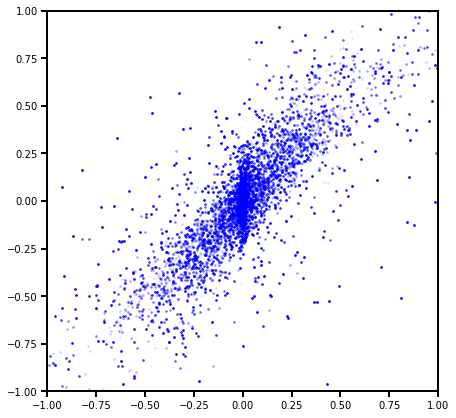

force loss : 0.10170316072250891


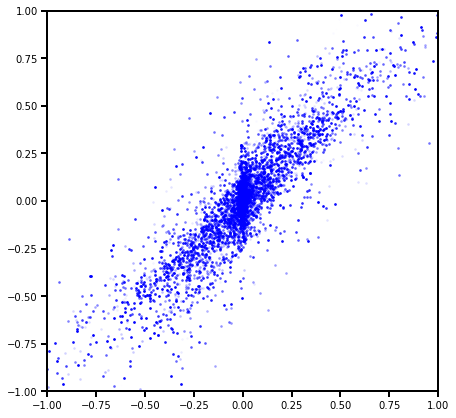

force loss : 0.09875236474033586


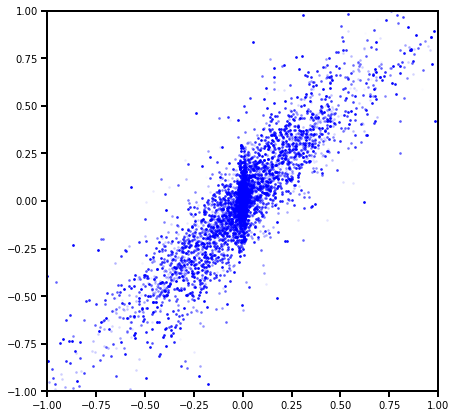

force loss : 0.09494923683289523


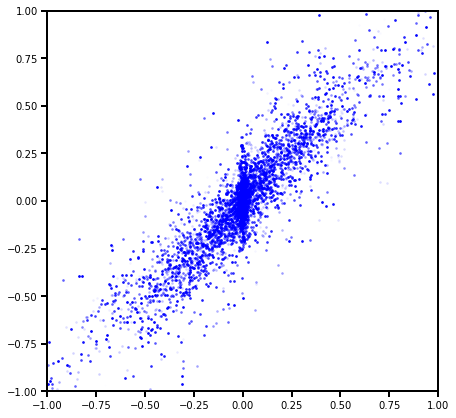

force loss : 0.0903423166224607


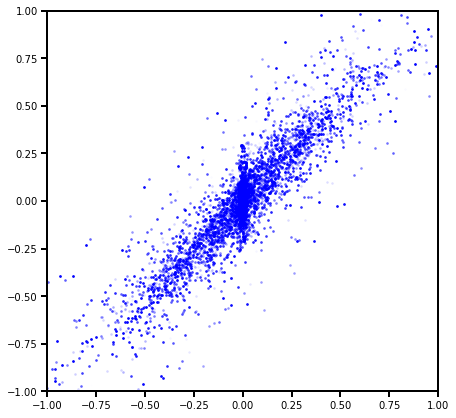

force loss : 0.0963077262127982


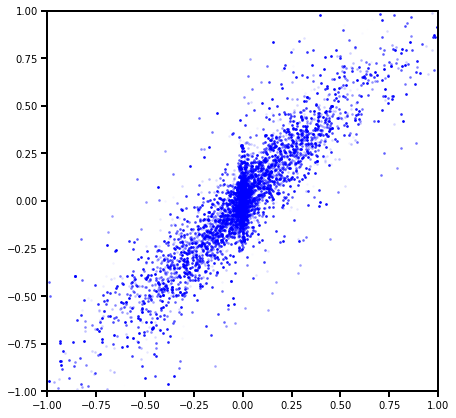

force loss : 0.09305305840601598


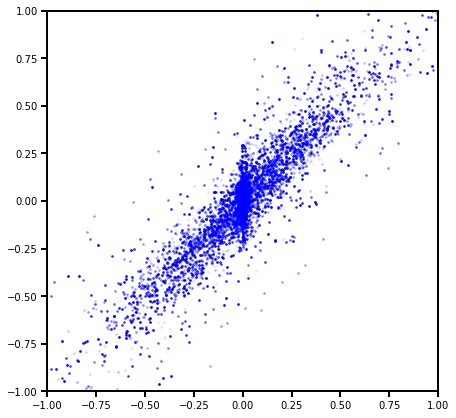

force loss : 0.09361151502208602


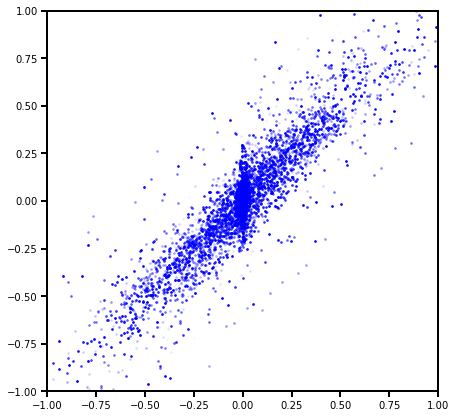

force loss : 0.09228268582233809


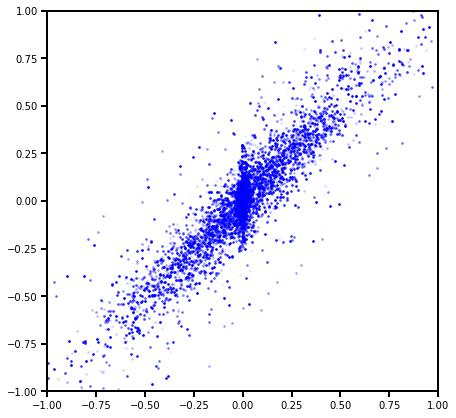

force loss : 0.09144665841433339


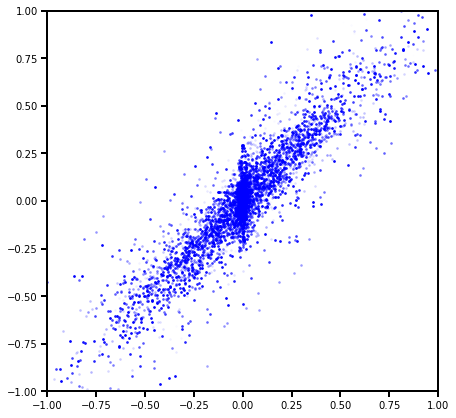

force loss : 0.09141728315586434


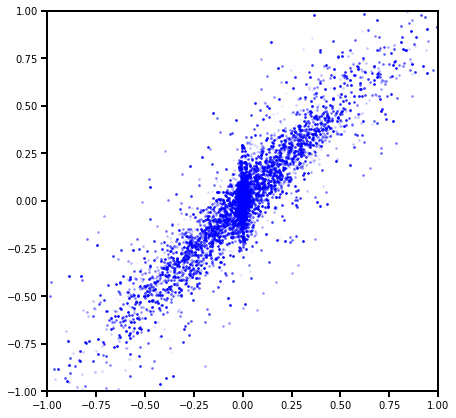

force loss : 0.09100854870184023


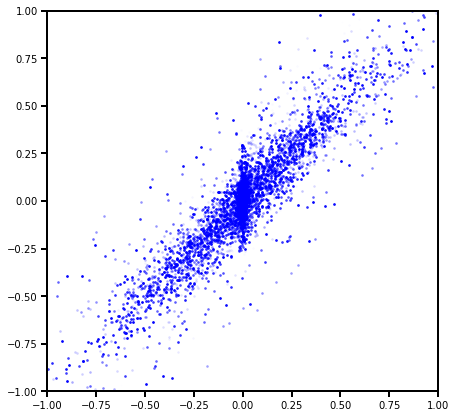

force loss : 0.09207266230220185


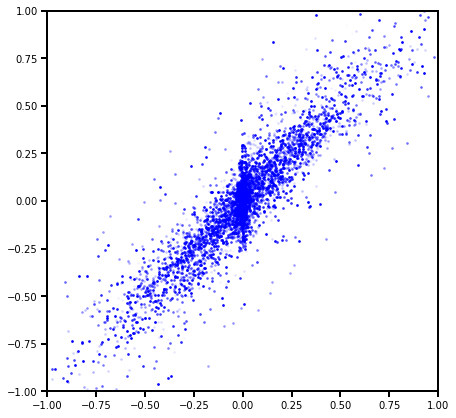

force loss : 0.08959026791547474


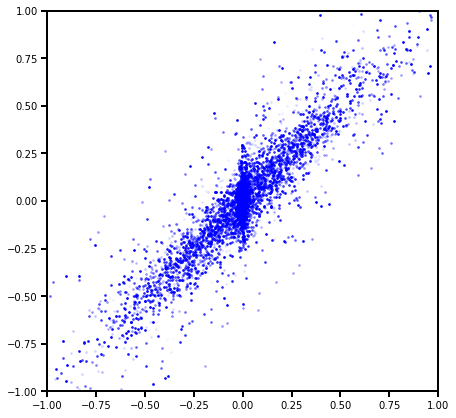

force loss : 0.08905534852380143


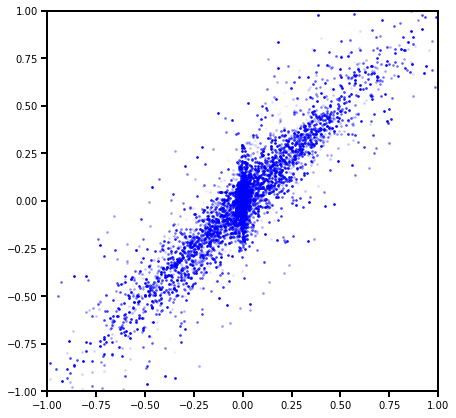

force loss : 0.08918082851328347


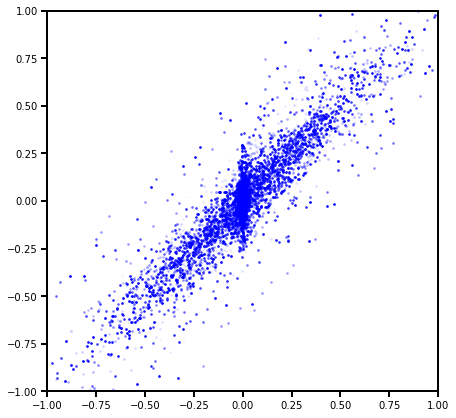

force loss : 0.08935598712554552


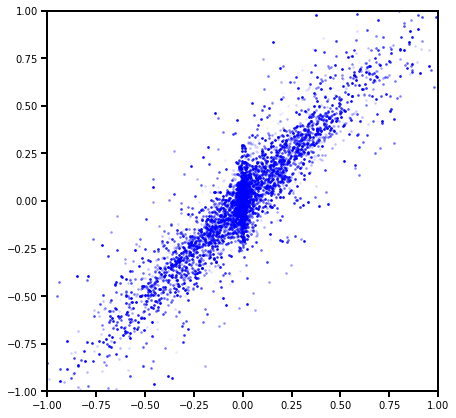

force loss : 0.08814185899787379


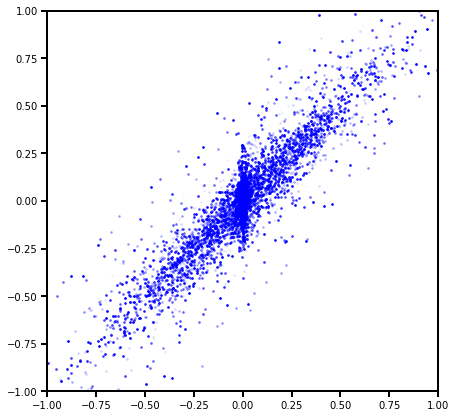

force loss : 0.08938305528092205


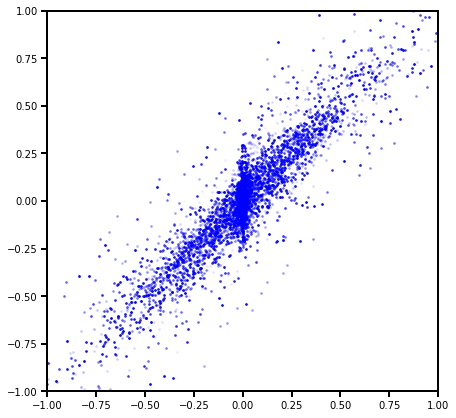

force loss : 0.08839287564046401


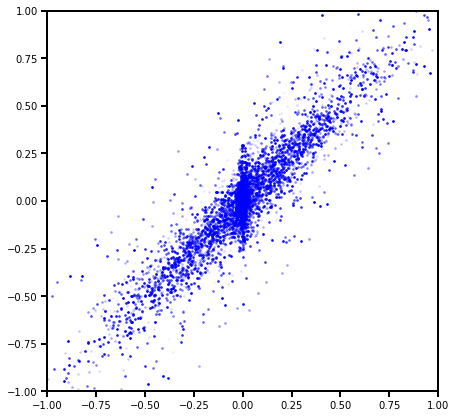

In [129]:
for i in range(20):
    validate(diffeq.model, f_traj, traj, optimizer=optimizer)

In [ ]:
# make sure the integrator is reasonable 

In [137]:
t_len = 1200

qt_data = torch.Tensor(traj[:t_len]).to(device)

skip = 5

steps = t_len // skip

v_data = torch.Tensor(v_traj[:t_len]).to(device)

In [138]:
optimizer = torch.optim.Adam(list(diffeq.parameters() ), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                              'min', 
                                              min_lr=5e-5, 
                                              verbose=True, factor = 0.5, patience= 10,
                                              threshold=5e-5)

0.037221912294626236


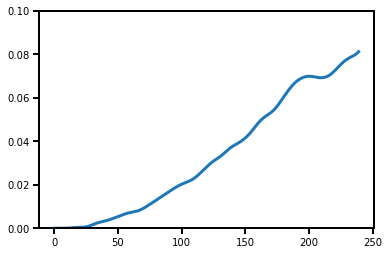

force loss : 0.08514974680834246


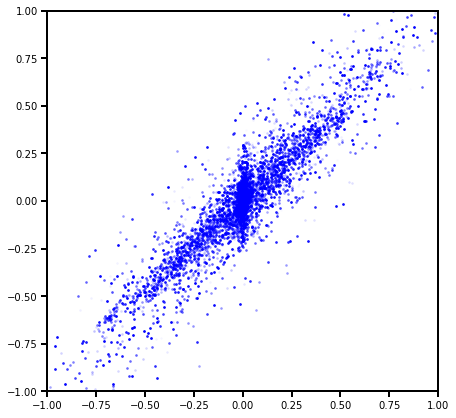

0.03637320175766945


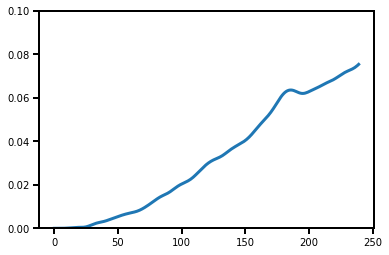

force loss : 0.0926371520119054


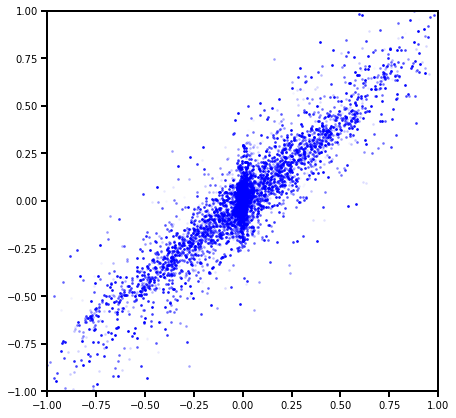

0.03616946563124657


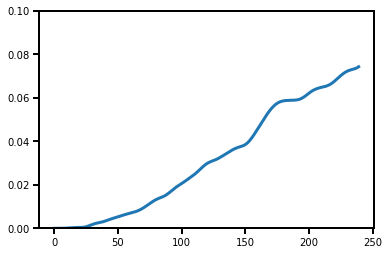

force loss : 0.11012290488172294


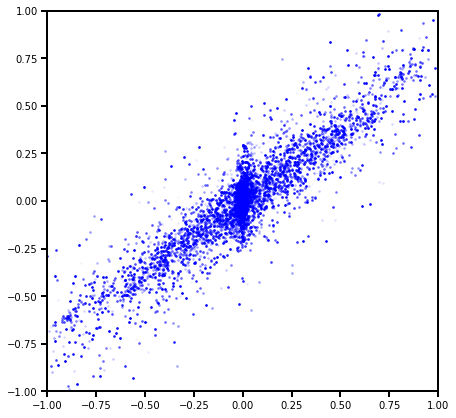

0.03659120202064514


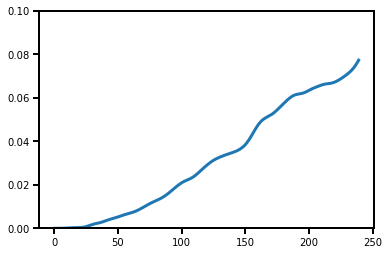

force loss : 0.13839925439061976


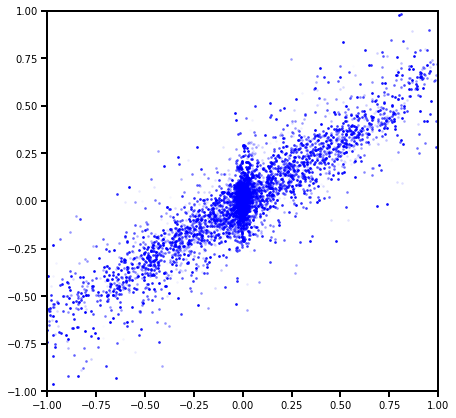

0.0356866791844368


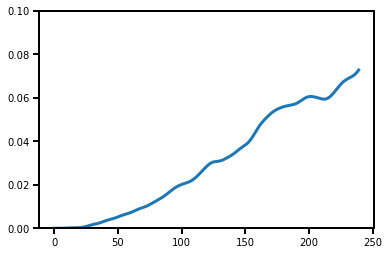

force loss : 0.17832902017840765


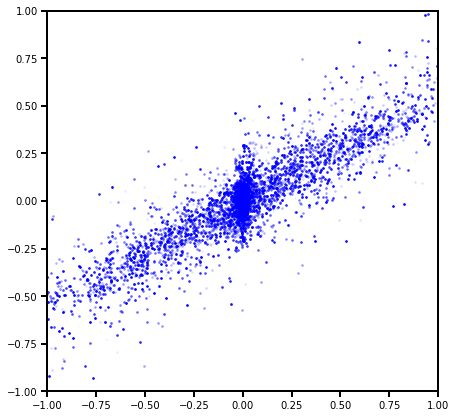

0.037312623113393784


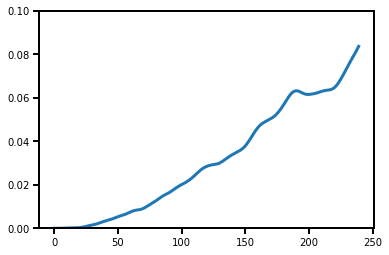

force loss : 0.23257789945692048


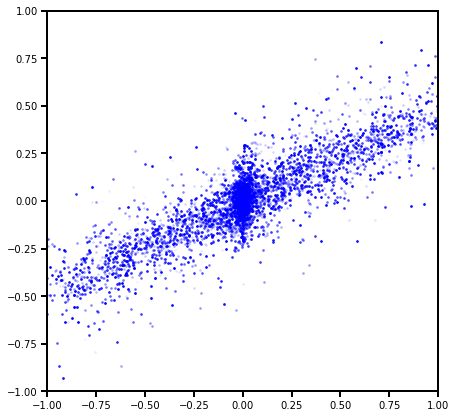

0.03877681866288185


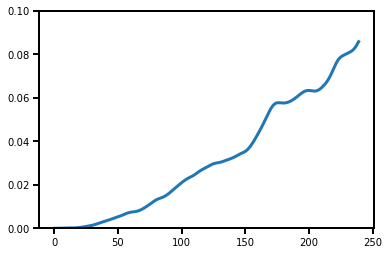

force loss : 0.29770547162769434


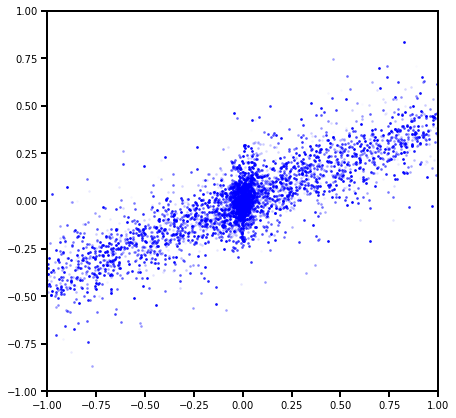

0.03709656000137329


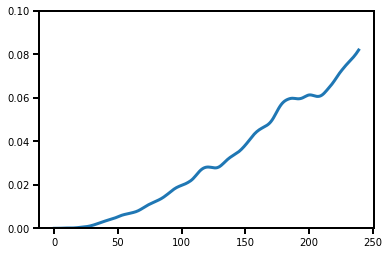

force loss : 0.340370364879307


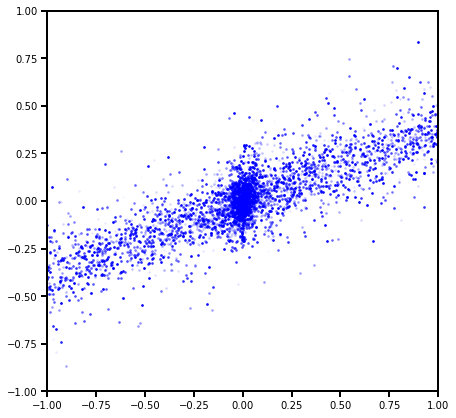

0.035637494176626205


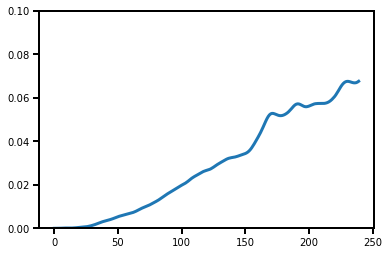

force loss : 0.38780340866038676


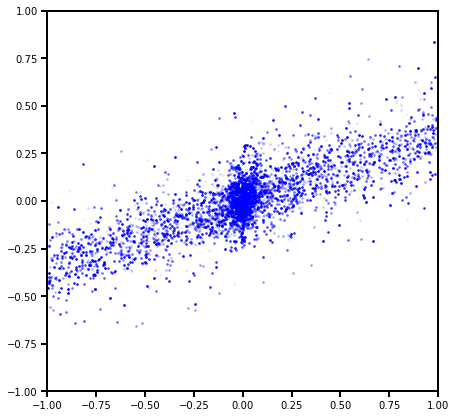

0.03752711042761803


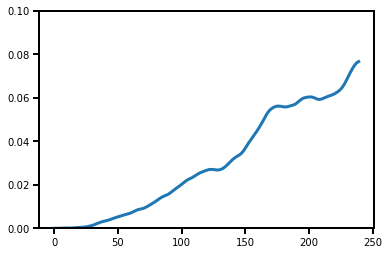

force loss : 0.34152456938772274


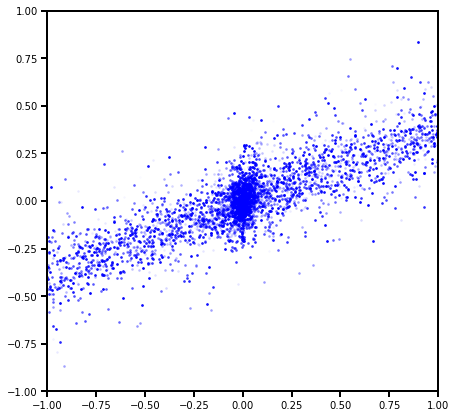

0.0340806320309639


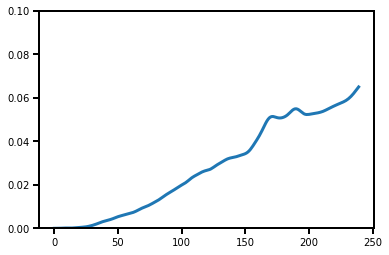

force loss : 0.3055952786278904


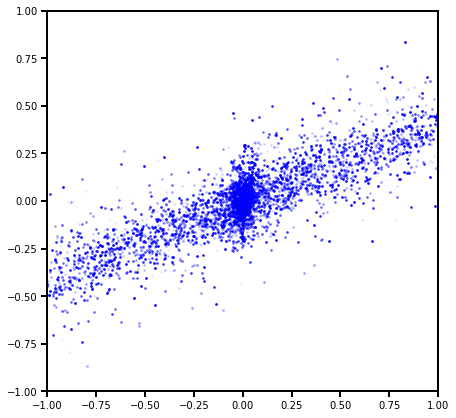

0.03764274716377258


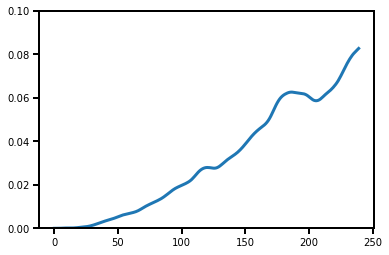

force loss : 0.27698733495142225


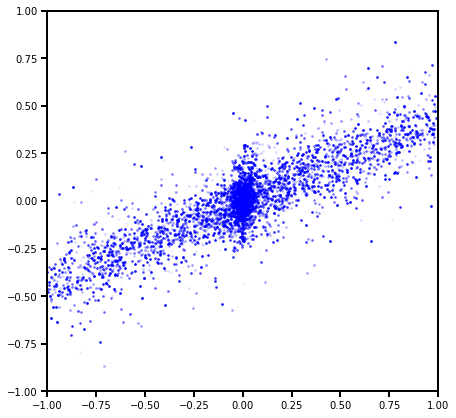

0.035634785890579224


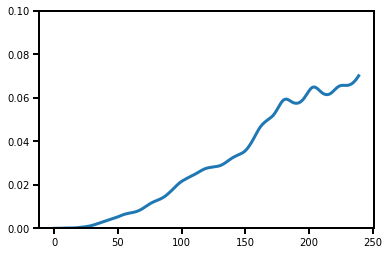

force loss : 0.2539395849619593


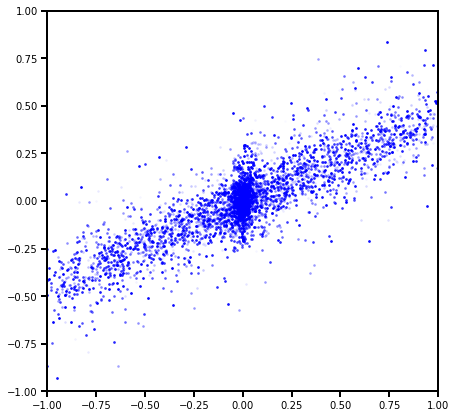

0.036214496940374374


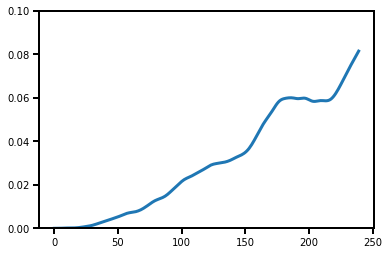

force loss : 0.23509077895852856


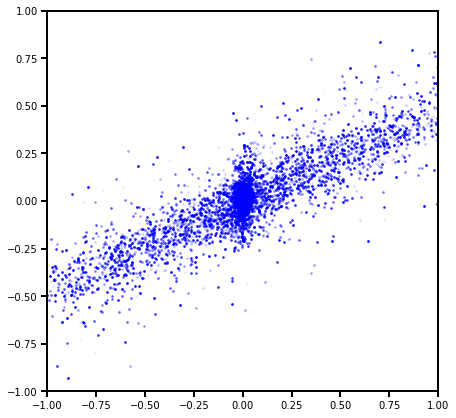

0.0394783653318882


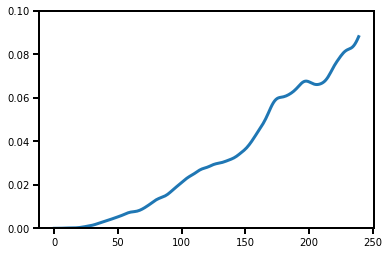

force loss : 0.21951603396494584


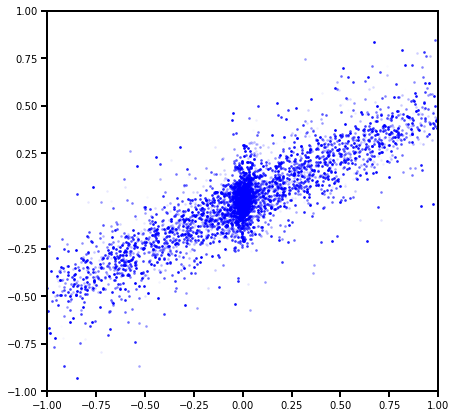

0.03743517026305199


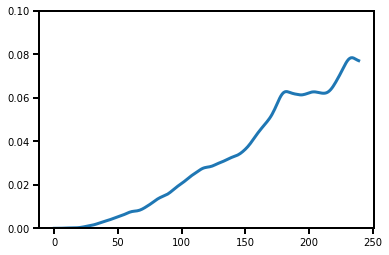

force loss : 0.20668620957915945


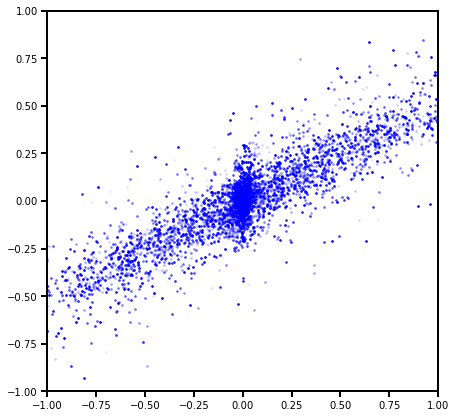

0.03722275421023369


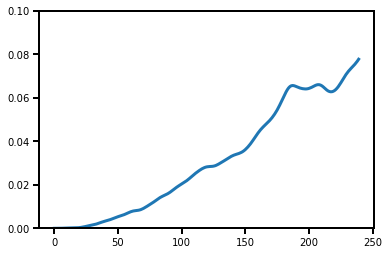

force loss : 0.1959194918548254


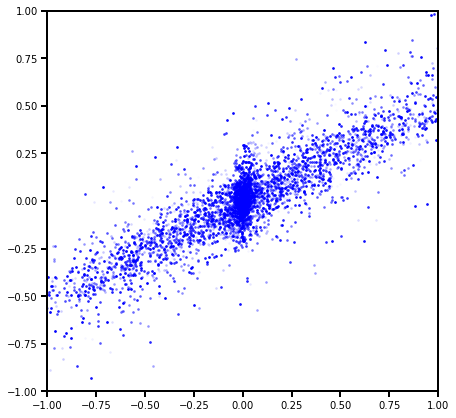

0.03759817034006119


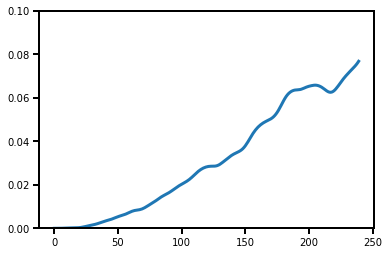

force loss : 0.18685236181083478


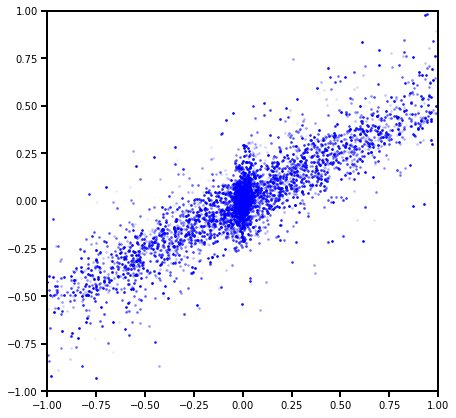

0.03636813908815384


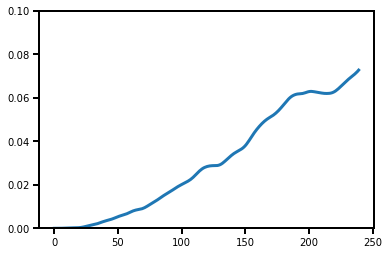

force loss : 0.17916327317182282


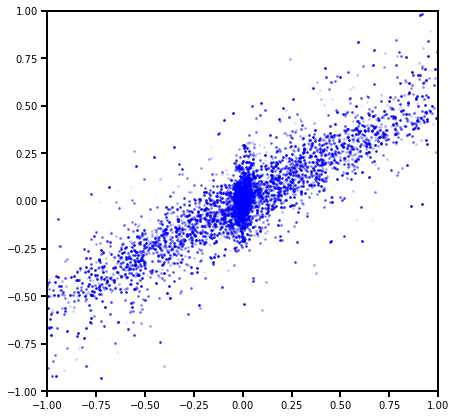

0.036007486283779144


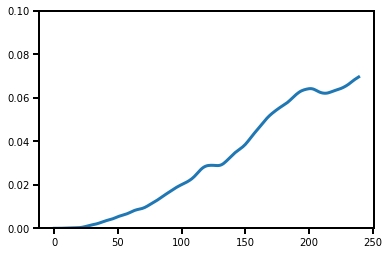

force loss : 0.17261193143694023


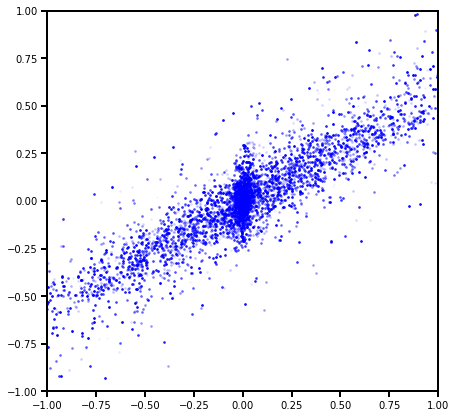

0.0359036847949028


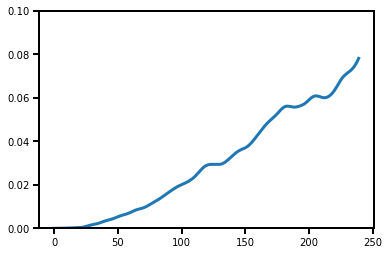

force loss : 0.1670083247853401


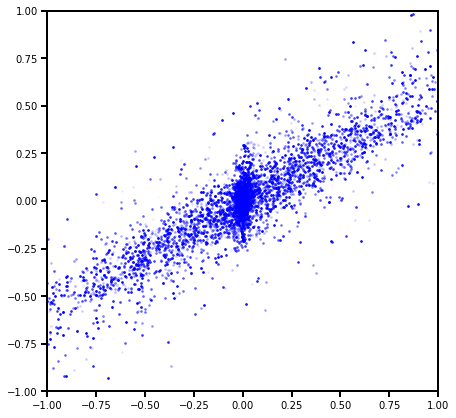

0.0344659760594368
Epoch    22: reducing learning rate of group 0 to 5.0000e-04.


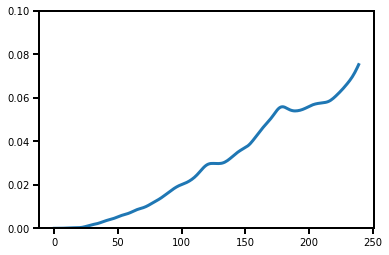

force loss : 0.16219617768113775


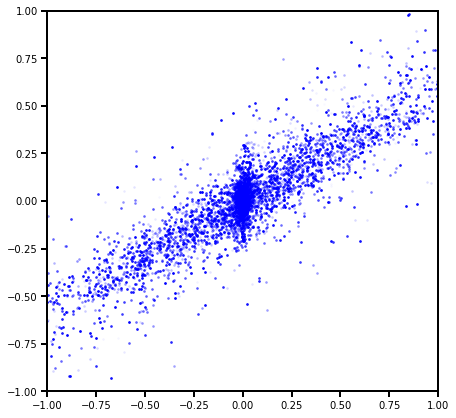

0.035462524741888046


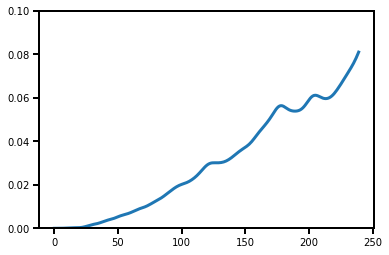

force loss : 0.1601060811514245


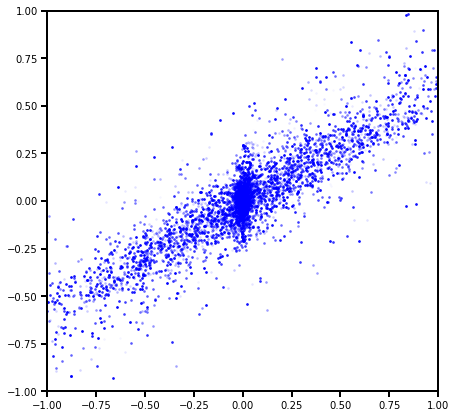

0.03521692752838135


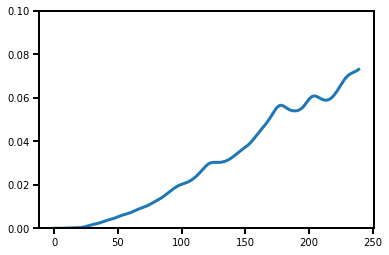

force loss : 0.15824586522758455


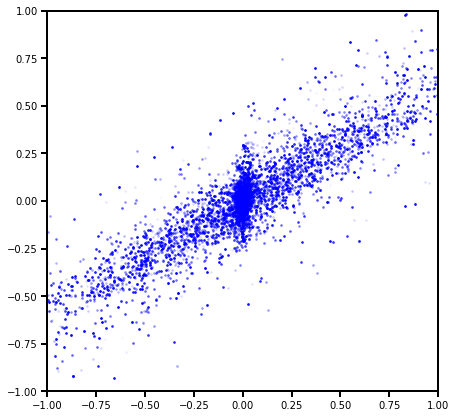

0.035157278180122375


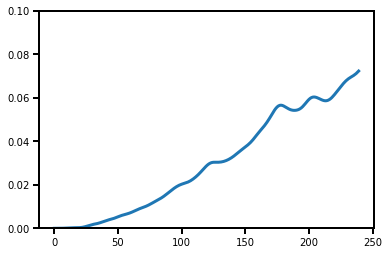

force loss : 0.1565809463311855


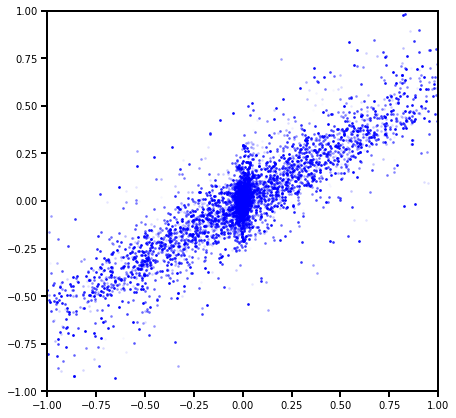

0.035147398710250854


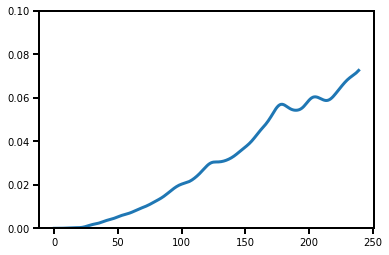

force loss : 0.15509110431473955


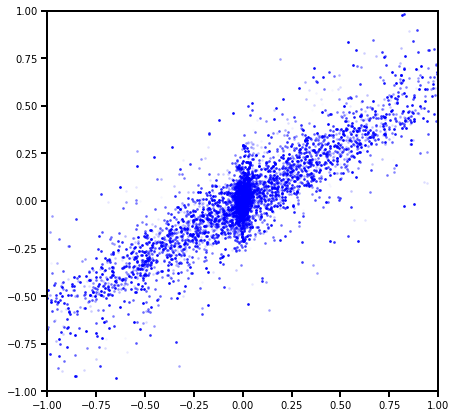

0.035069432109594345


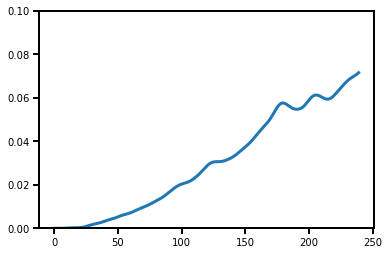

force loss : 0.15375976835874686


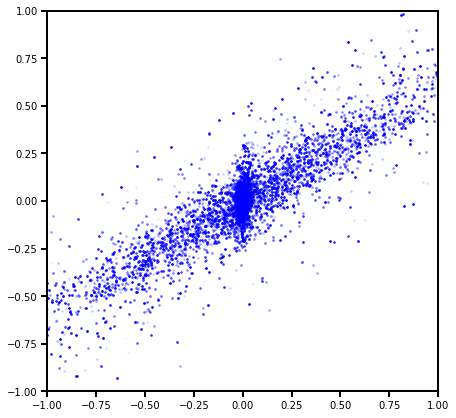

0.03508497402071953


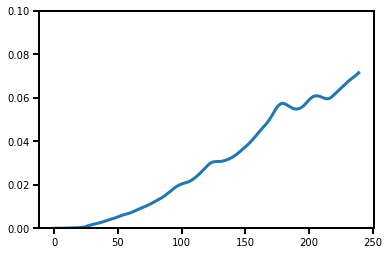

force loss : 0.15257578091065688


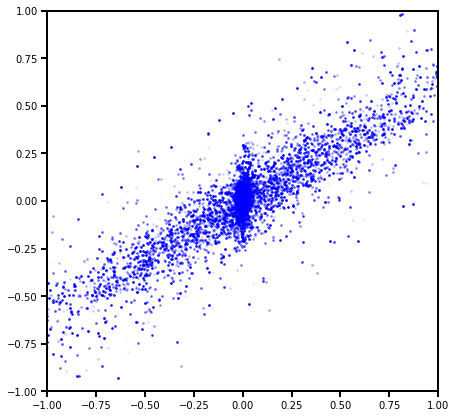

0.035063326358795166


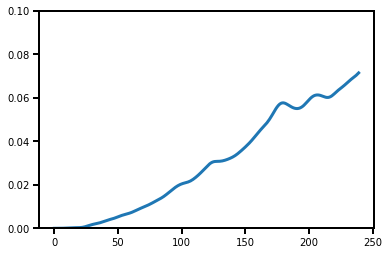

force loss : 0.15151451836179072


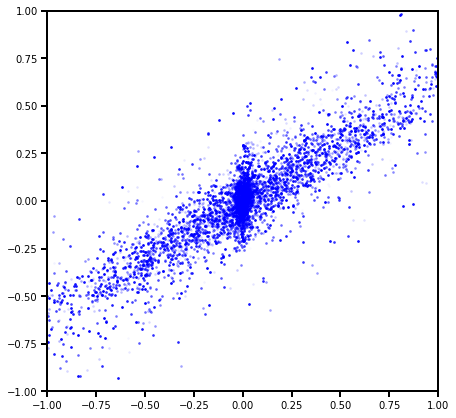

0.035113122314214706


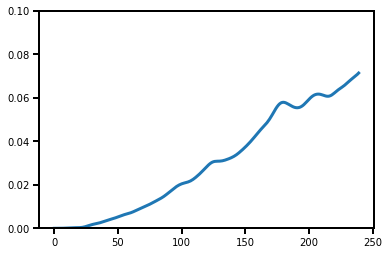

force loss : 0.15055934132489943


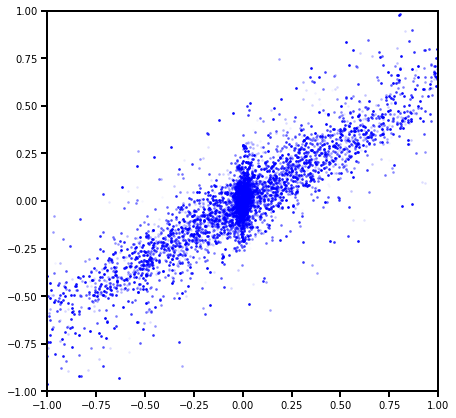

0.03508879989385605


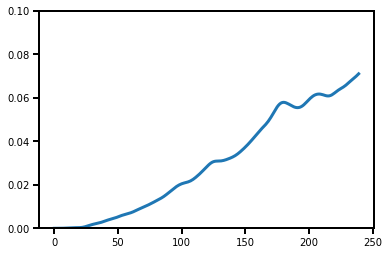

force loss : 0.14969929587796219


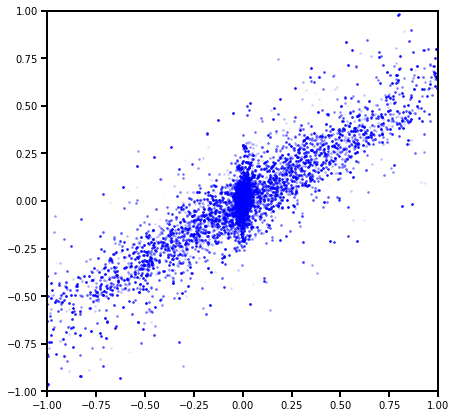

0.03502224385738373


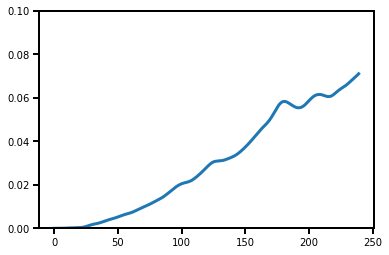

force loss : 0.1489269167072791


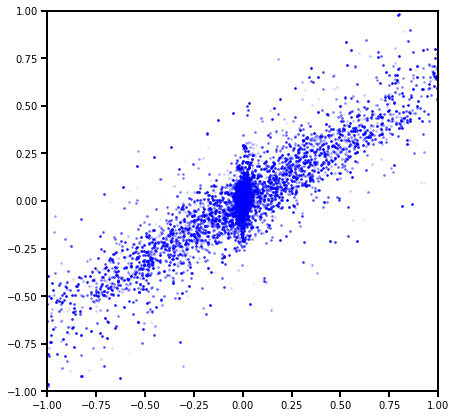

0.03505921736359596
Epoch    33: reducing learning rate of group 0 to 2.5000e-04.


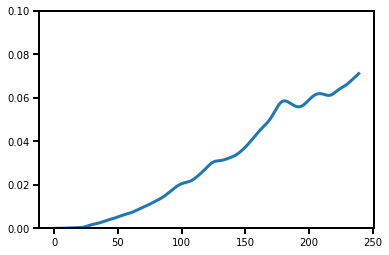

force loss : 0.14823420967598608


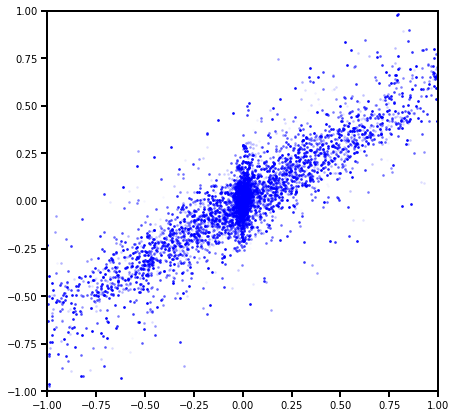

0.03698936104774475


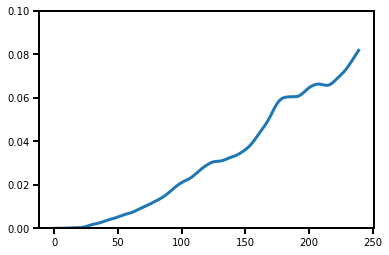

force loss : 0.14792067490350036


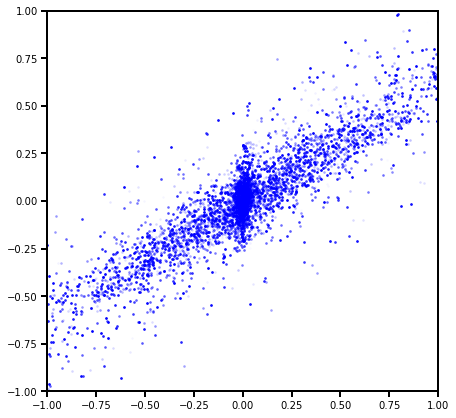

0.03700553998351097


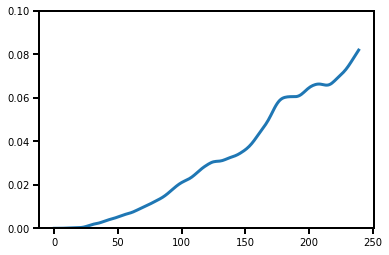

force loss : 0.14763626702746055


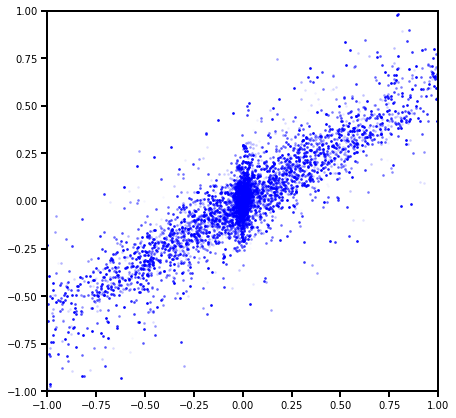

0.03684490546584129


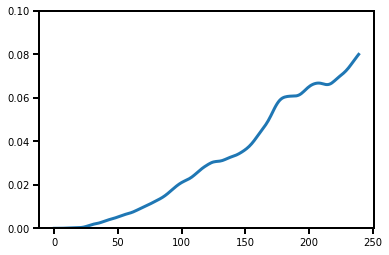

force loss : 0.14737839313378012


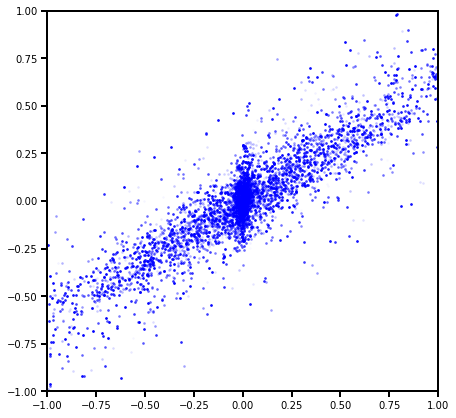

0.03686060756444931


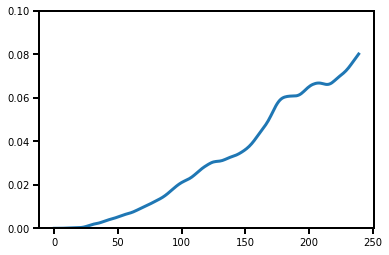

force loss : 0.1471442157276591


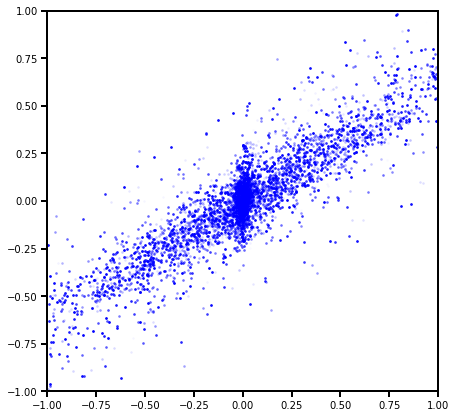

0.036908846348524094


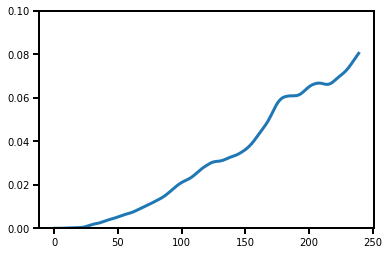

force loss : 0.14693166959778706


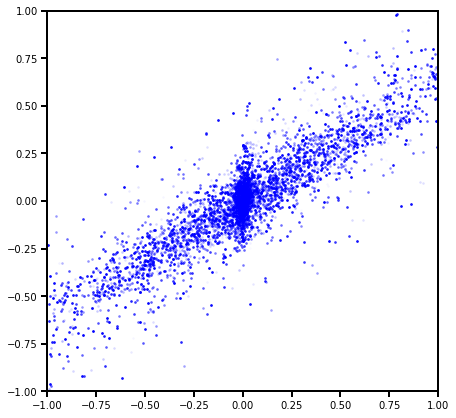

0.03691989555954933


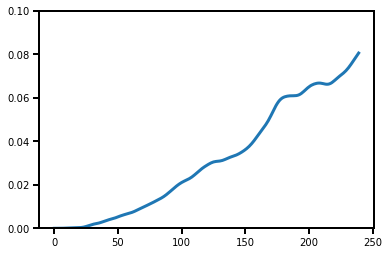

force loss : 0.14673929448638642


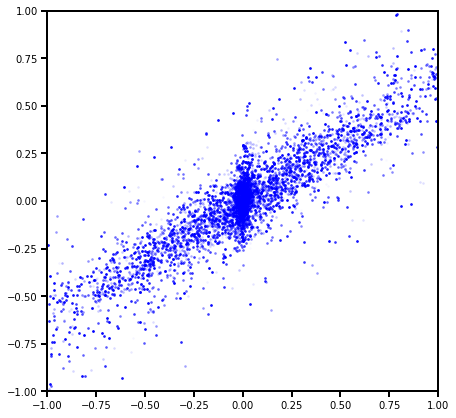

0.03692902624607086


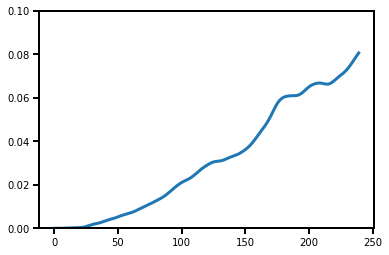

force loss : 0.14656477679211394


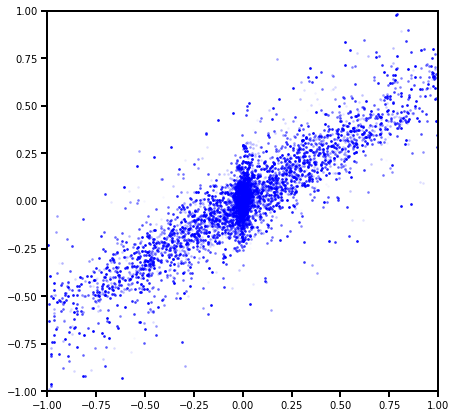

0.036913417279720306


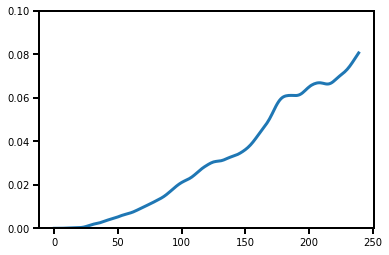

force loss : 0.14640625975185767


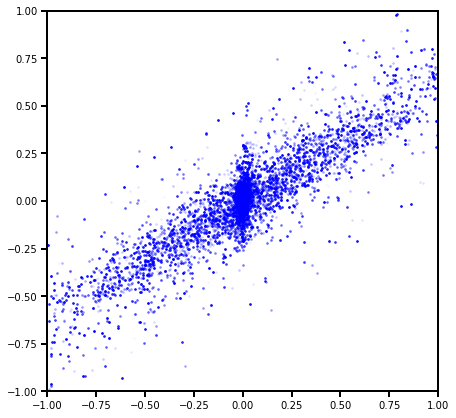

0.03691980615258217


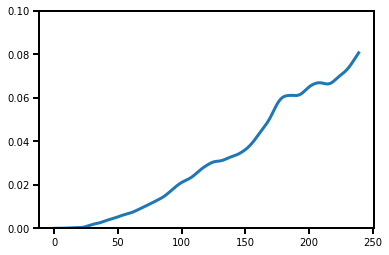

force loss : 0.14626220316815197


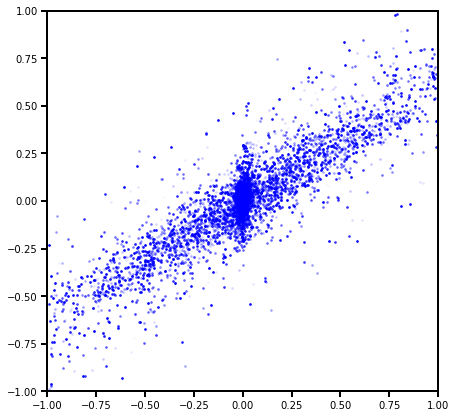

0.03692518174648285


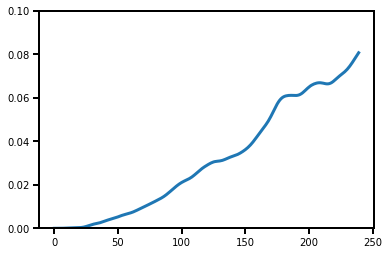

force loss : 0.14613175487383864


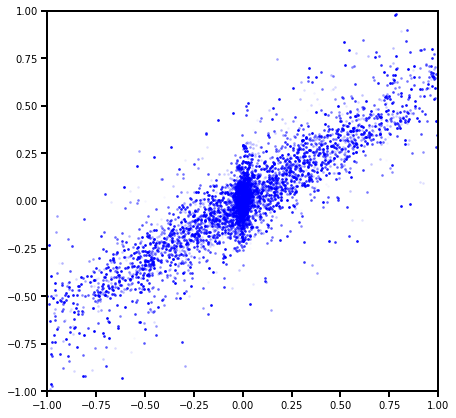

0.03693016245961189
Epoch    44: reducing learning rate of group 0 to 1.2500e-04.


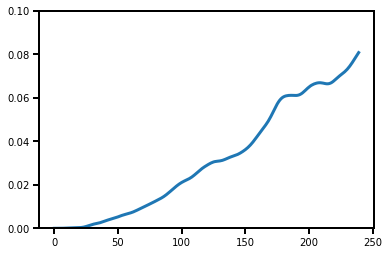

force loss : 0.14601355735072516


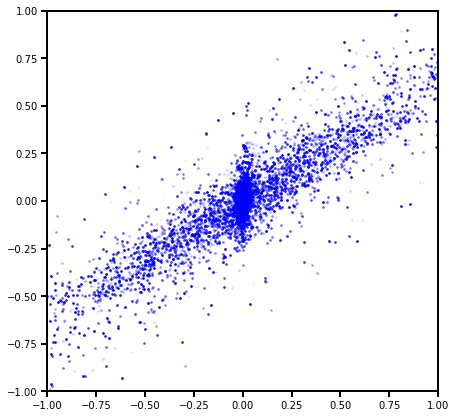

0.036933641880750656


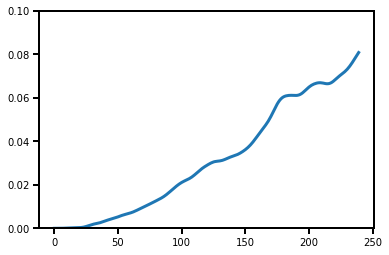

force loss : 0.1459598455550079


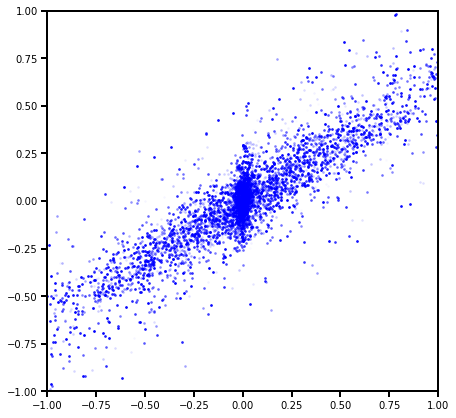

0.03693500906229019


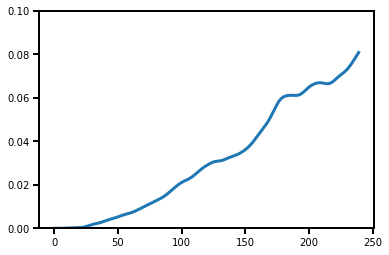

force loss : 0.14591101607433835


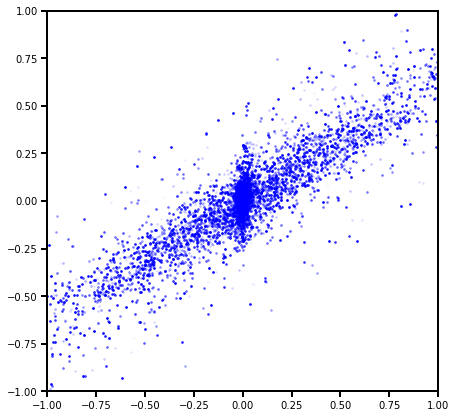

0.036940667778253555


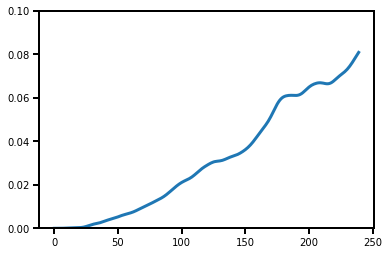

force loss : 0.14586665262853293


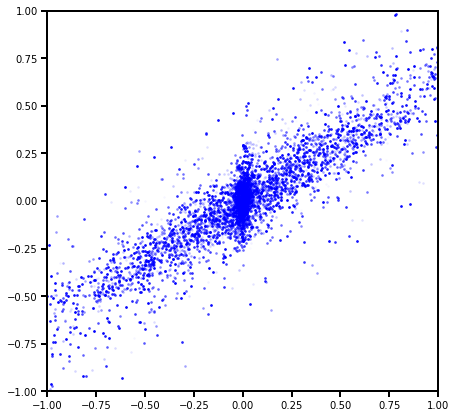

0.03694137930870056


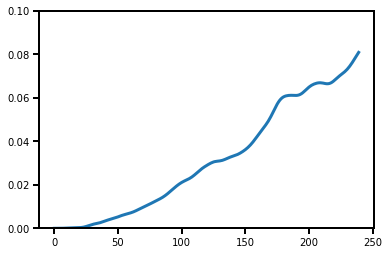

force loss : 0.14582638016768865


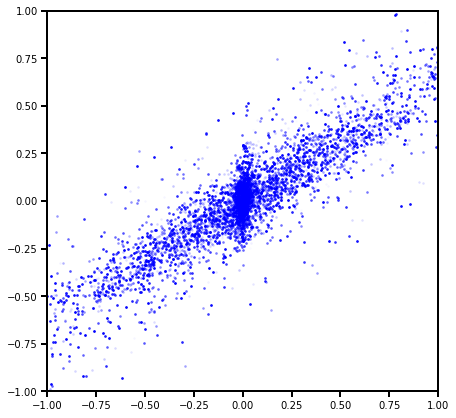

0.03694179281592369


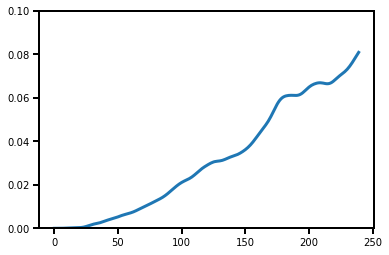

force loss : 0.14578986700092042


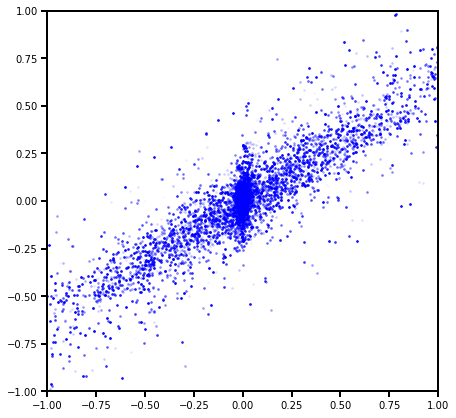

0.03694194182753563


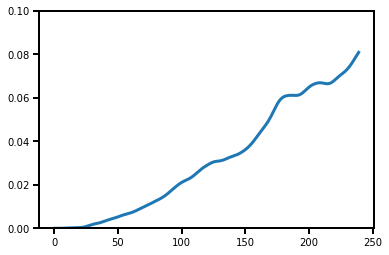

force loss : 0.14575671001260443


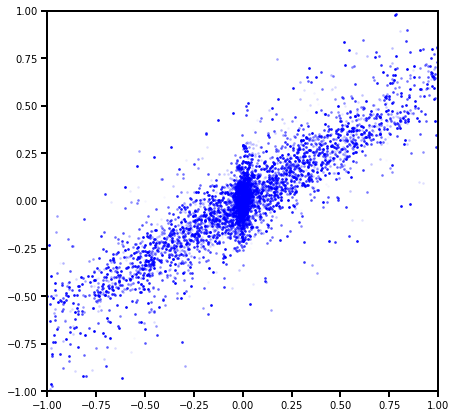

0.036941833794116974


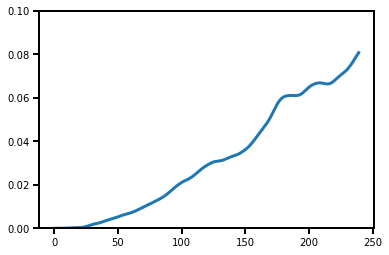

force loss : 0.14572665162552567


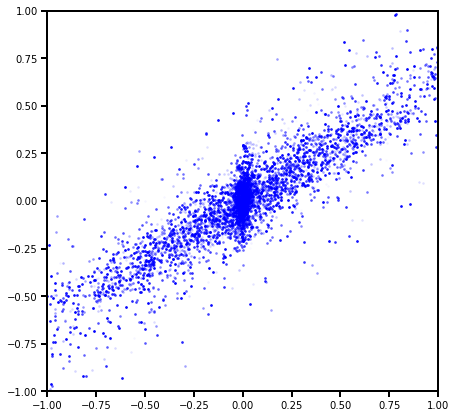

0.03694149851799011


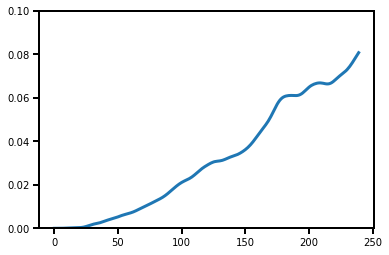

force loss : 0.14569937460180513


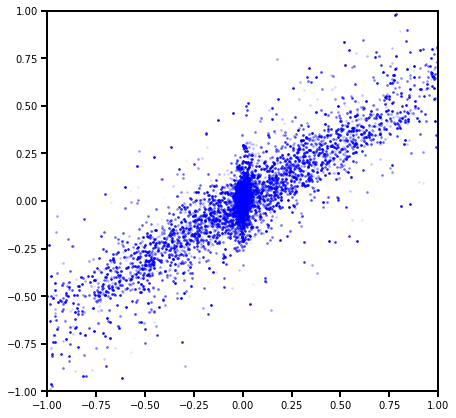

0.036940984427928925


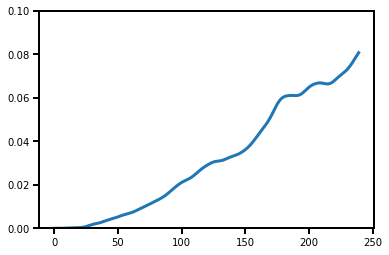

force loss : 0.145674580245986


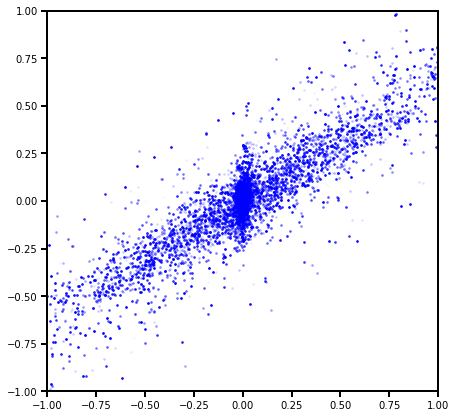

0.03694017231464386


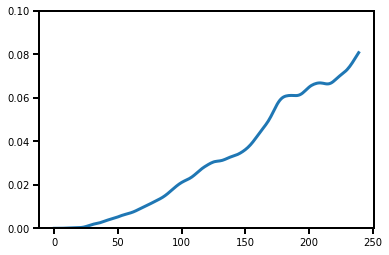

force loss : 0.14565205658064748


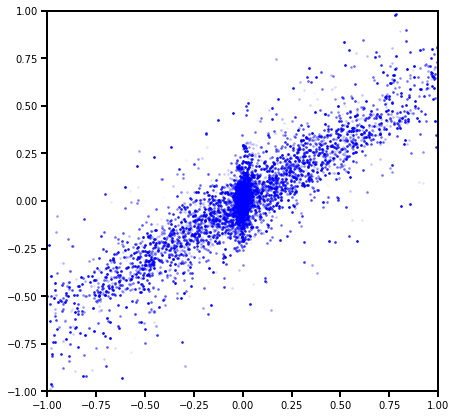

0.03693930804729462
Epoch    55: reducing learning rate of group 0 to 6.2500e-05.


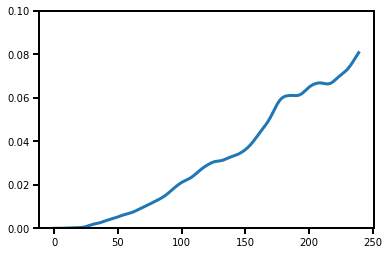

force loss : 0.14563161851768208


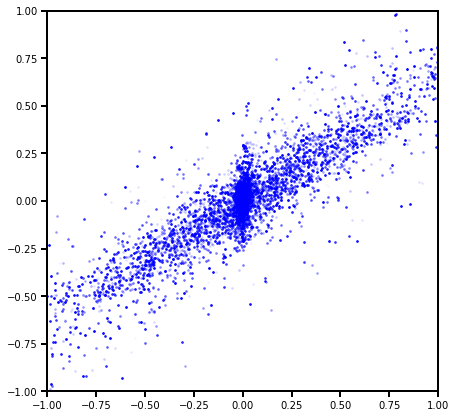

0.03693825751543045


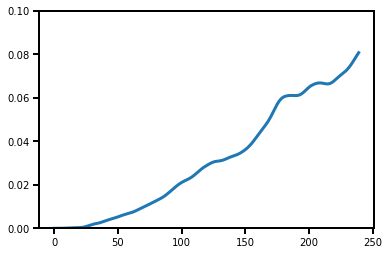

force loss : 0.1456223333016374


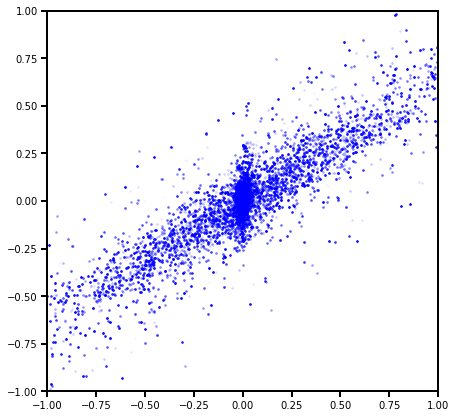

0.036937642842531204


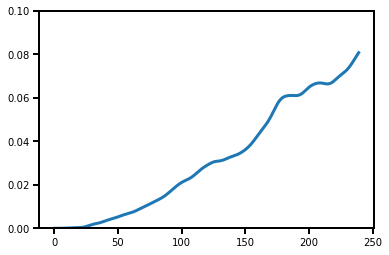

force loss : 0.145613905126439


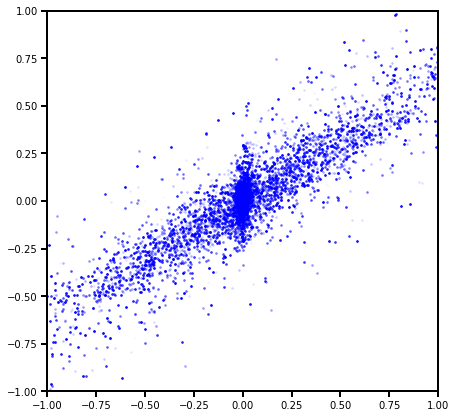

0.036936964839696884


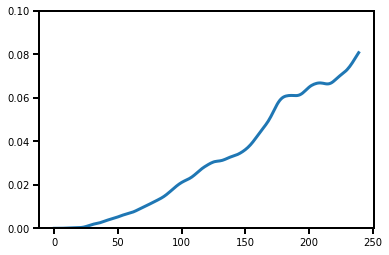

force loss : 0.1456062787569555


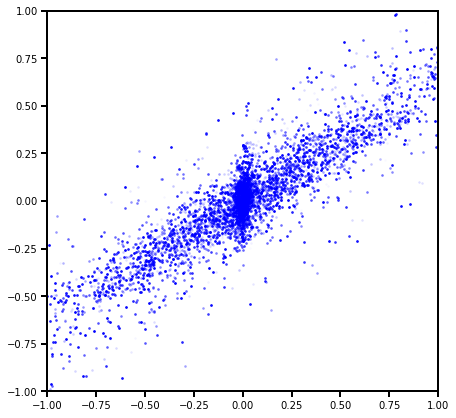

0.036936234682798386


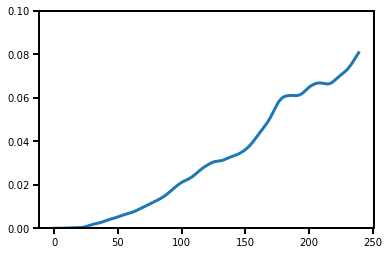

force loss : 0.14559934338680783


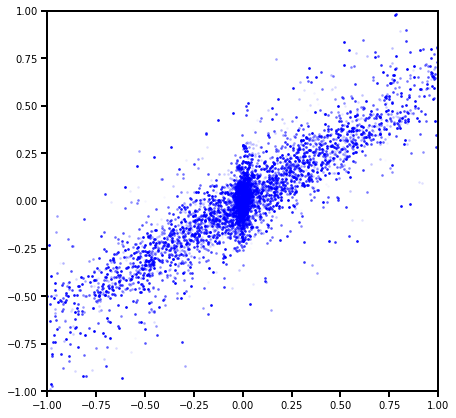

0.0369354784488678


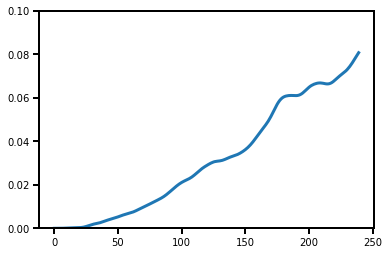

force loss : 0.14559304473319448


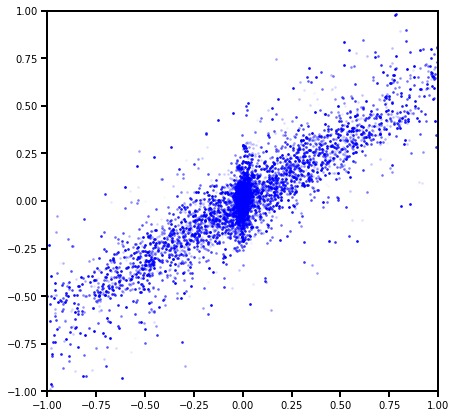

0.03693467378616333


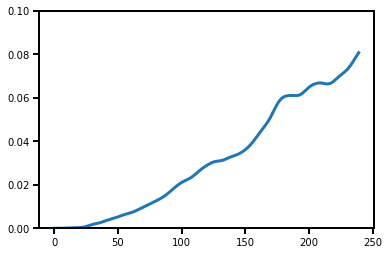

force loss : 0.14558735428223932


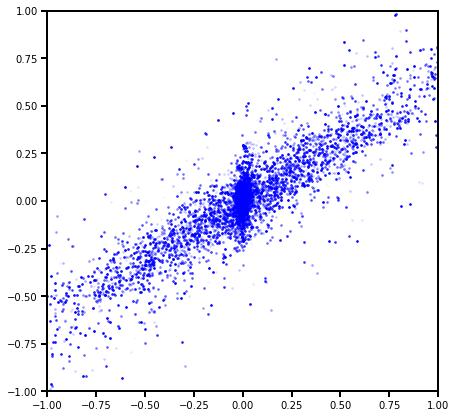

0.036933790892362595


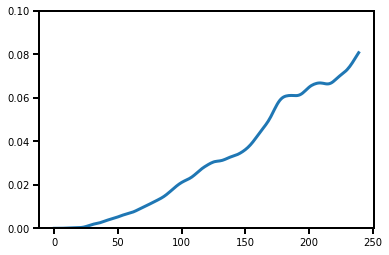

force loss : 0.14558217814542296


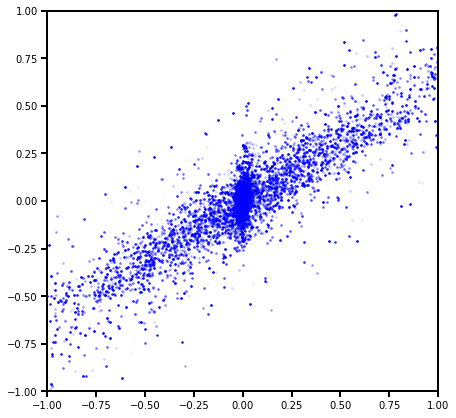

0.036932848393917084


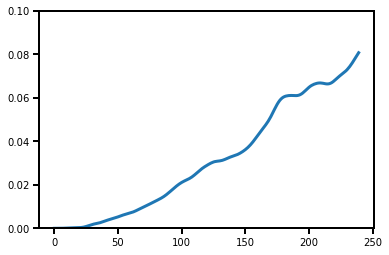

force loss : 0.1455774748123678


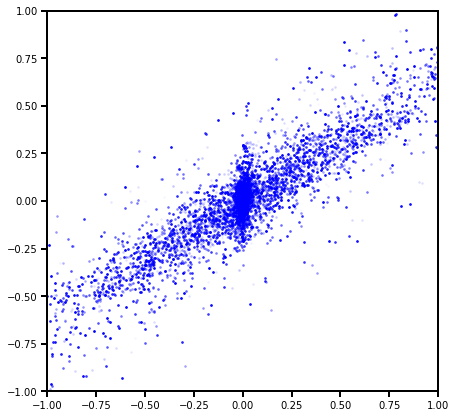

0.03693189471960068


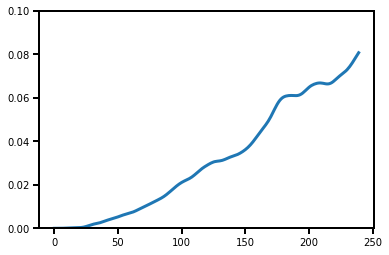

force loss : 0.1455732025486186


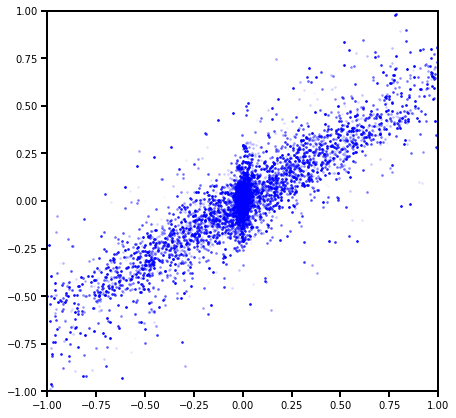

0.0369308777153492


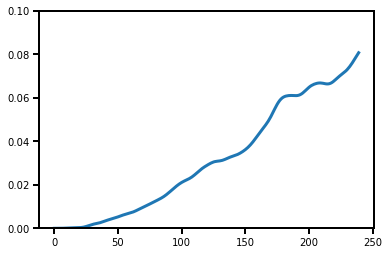

force loss : 0.14556934880582909


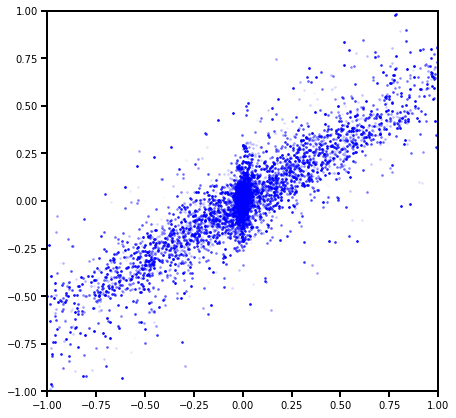

0.03692985698580742
Epoch    66: reducing learning rate of group 0 to 5.0000e-05.


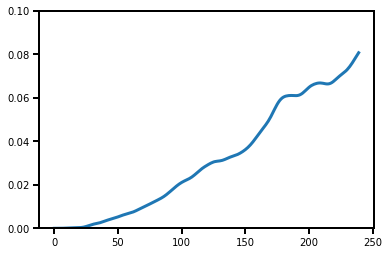

force loss : 0.1455658253534396


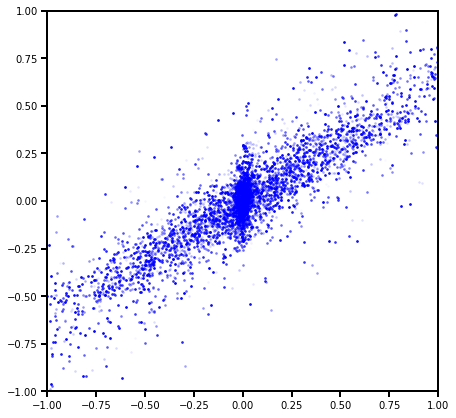

0.03692876920104027


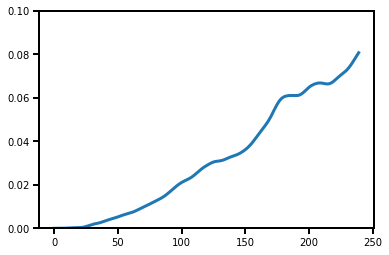

force loss : 0.14556329193195902


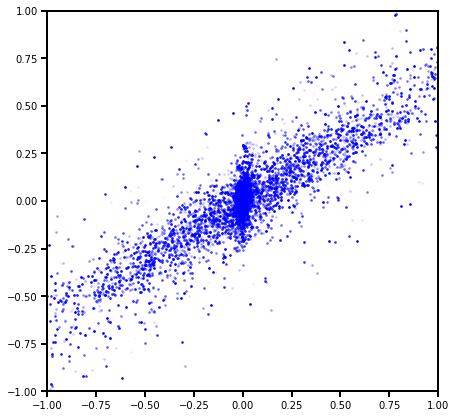

0.03692791238427162


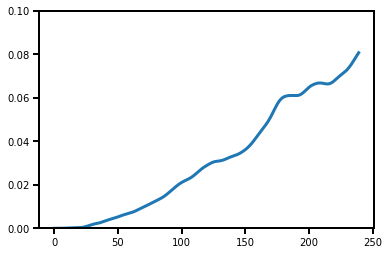

force loss : 0.14556101205429636


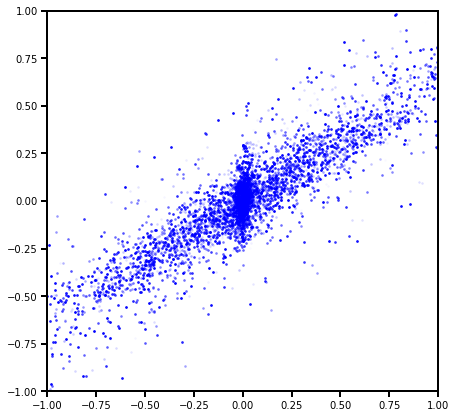

0.0369269922375679


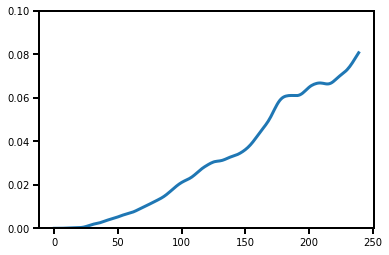

force loss : 0.14555891496794565


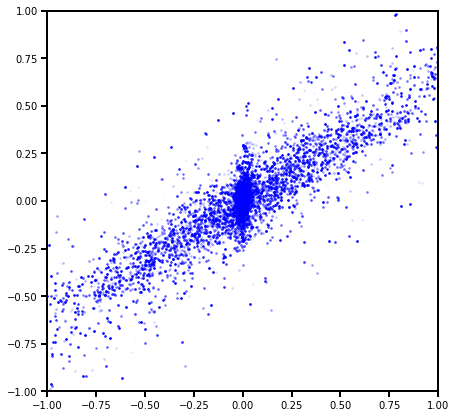

0.036926113069057465


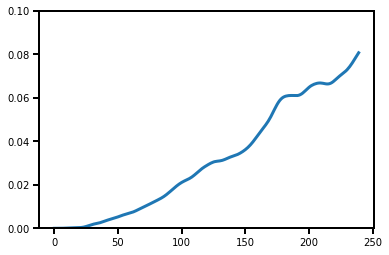

force loss : 0.14555702515338598


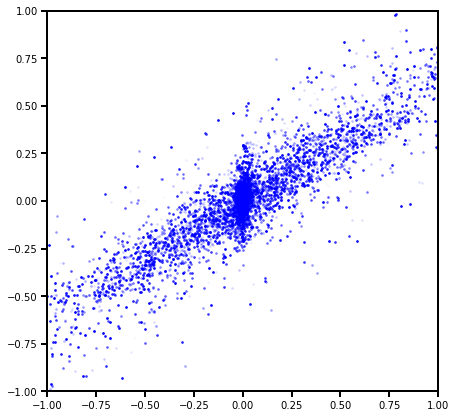

0.036910127848386765


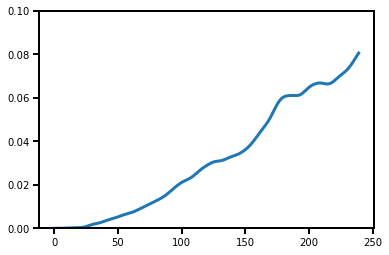

force loss : 0.1455553045734427


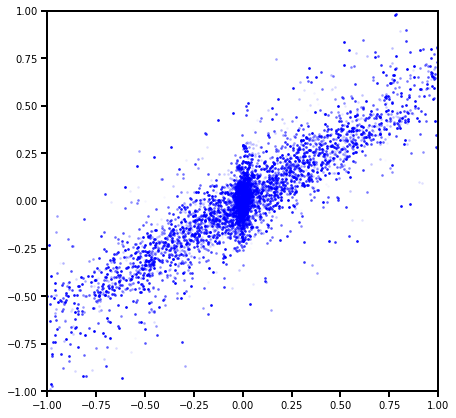

0.03690918907523155


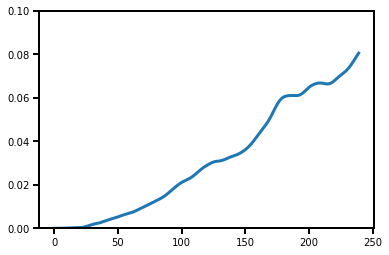

force loss : 0.1455537690816069


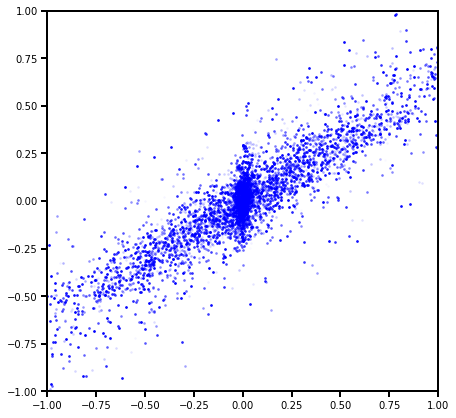

0.036908213049173355


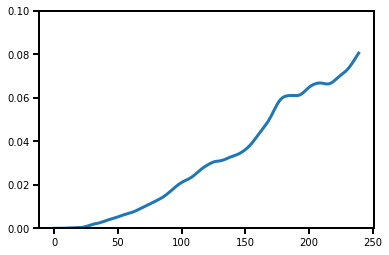

force loss : 0.1455523706692502


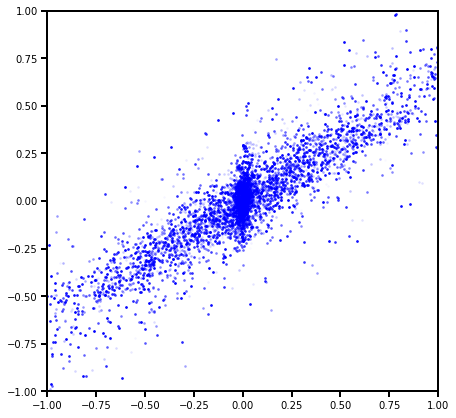

0.036906998604536057


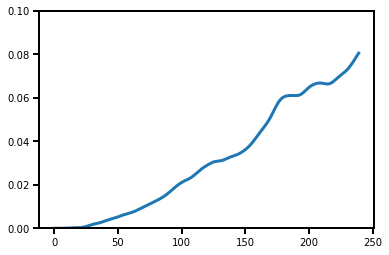

force loss : 0.14555108076647708


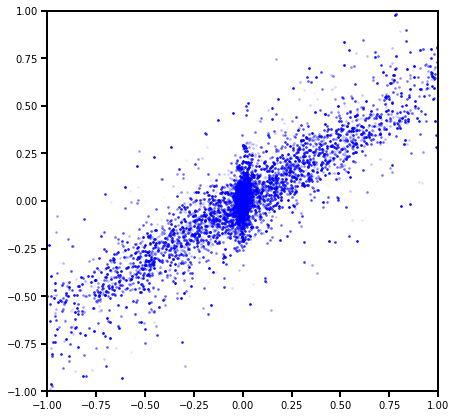

0.03690597042441368


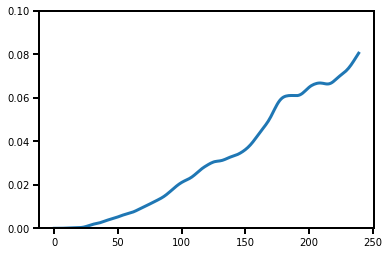

force loss : 0.14554994407677113


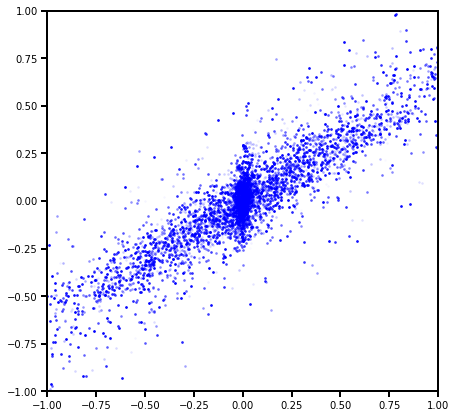

0.0369049608707428


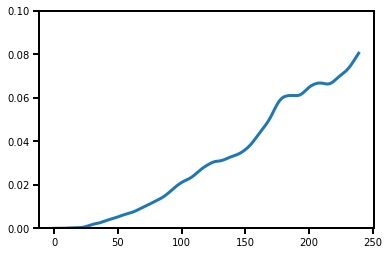

force loss : 0.14554886514306964


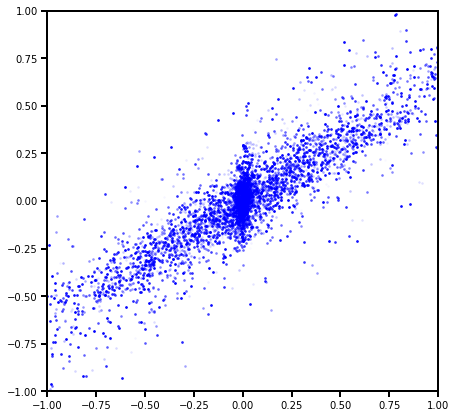

0.03690388798713684


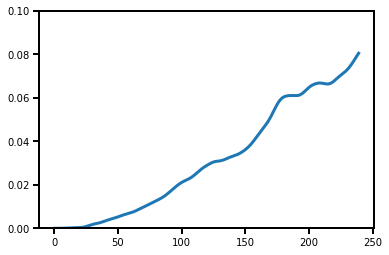

force loss : 0.14554790429826966


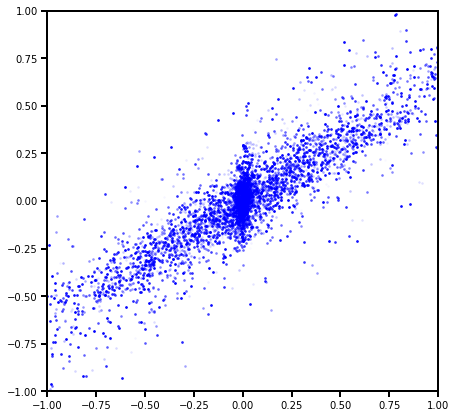

0.03690288960933685


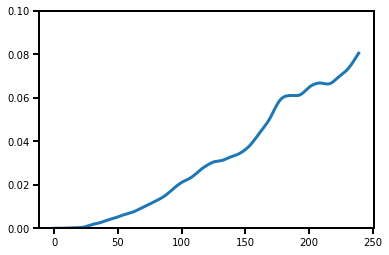

force loss : 0.14554703089975773


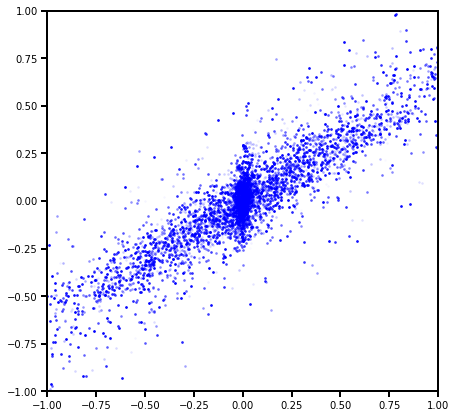

0.0369018130004406


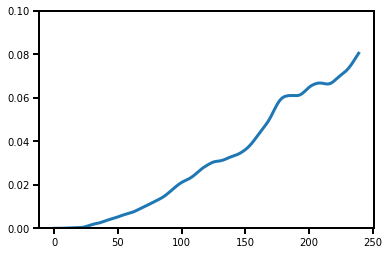

force loss : 0.14554627519801147


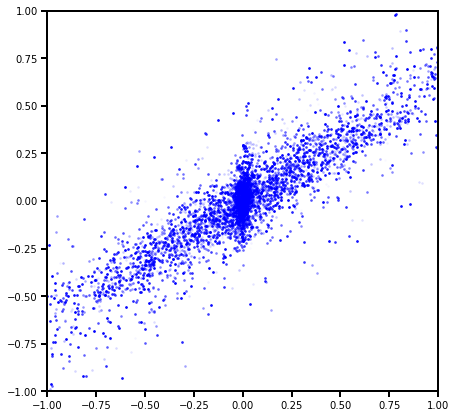

0.036900728940963745


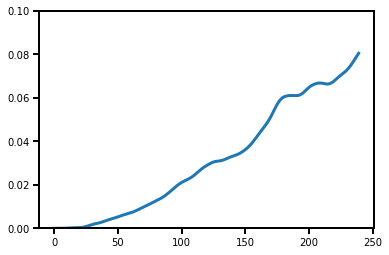

force loss : 0.14554555406023686


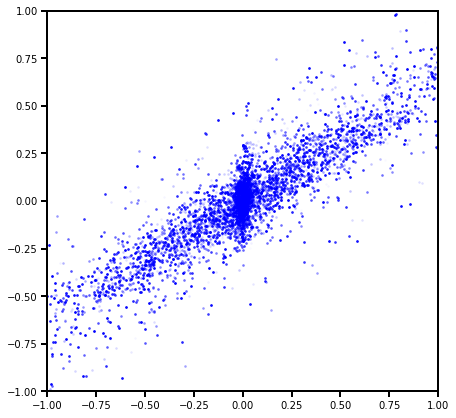

0.0368996299803257


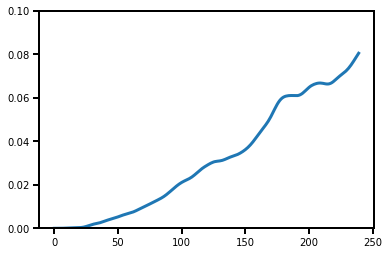

force loss : 0.14554492356185628


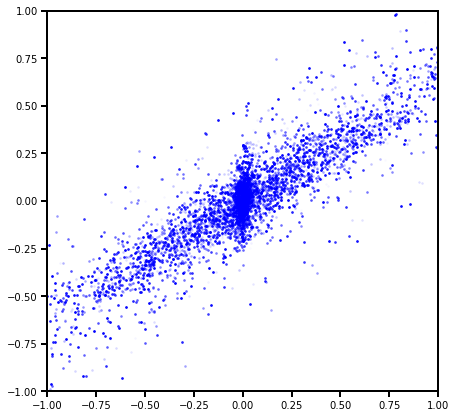

0.03689855337142944


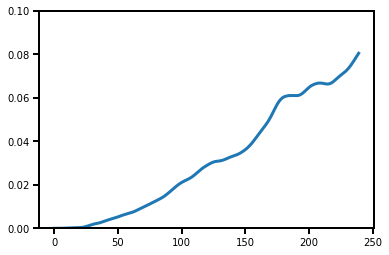

force loss : 0.14554433978365777


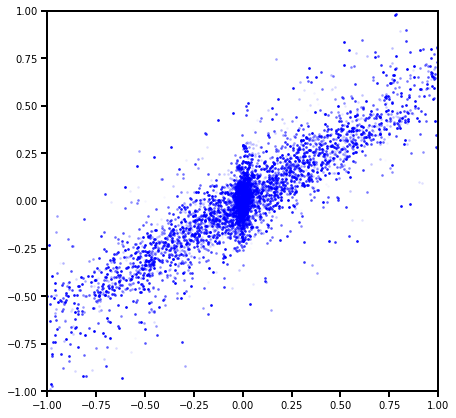

0.0368974395096302


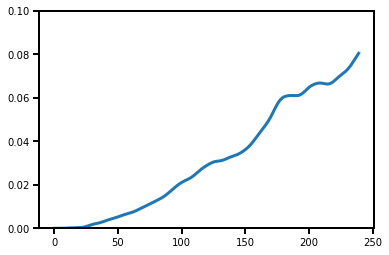

force loss : 0.14554380082098164


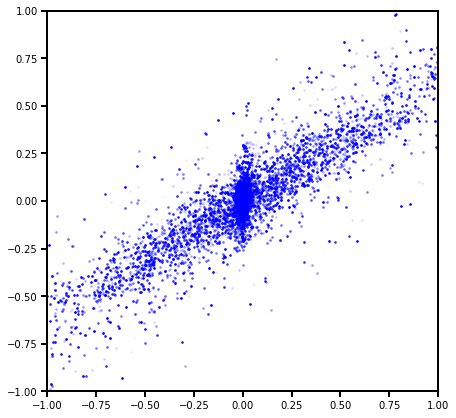

0.03689632564783096


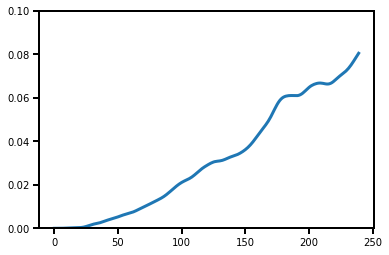

force loss : 0.14554331490868017


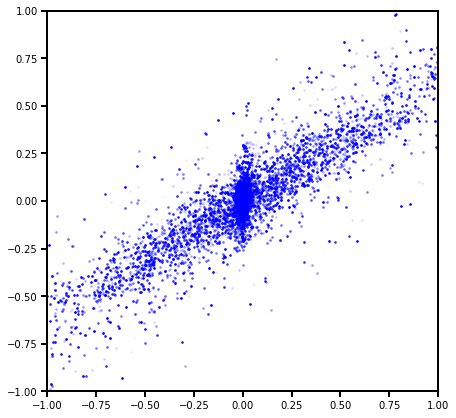

0.03689522296190262


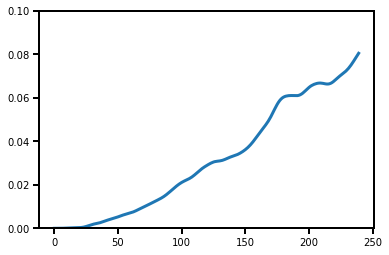

force loss : 0.14554290036509807


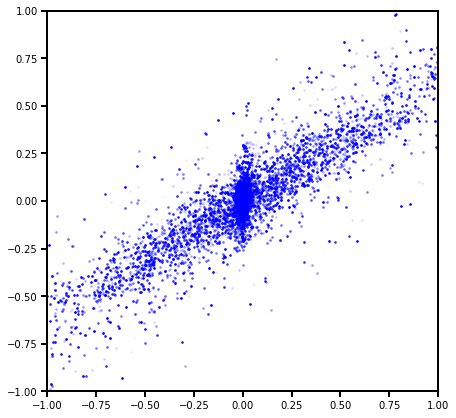

0.03689403459429741


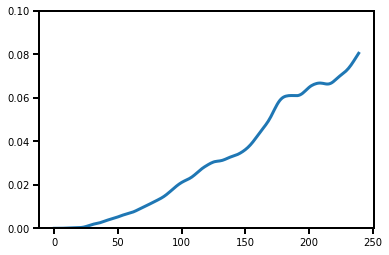

force loss : 0.145542523354516


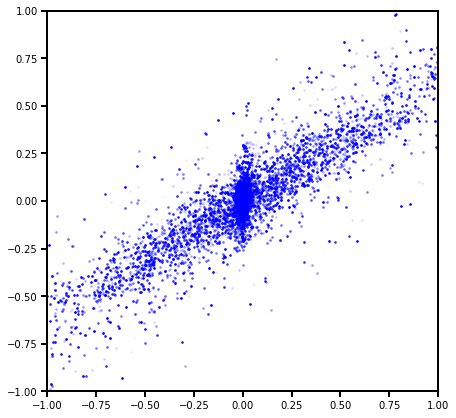

0.036892954260110855


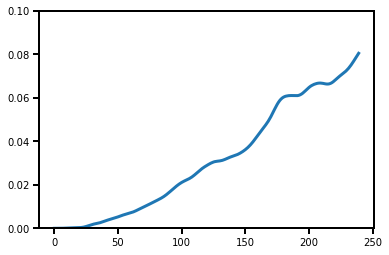

force loss : 0.14554215592325181


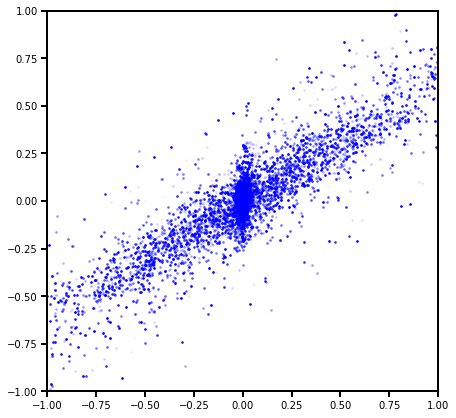

0.036891769617795944


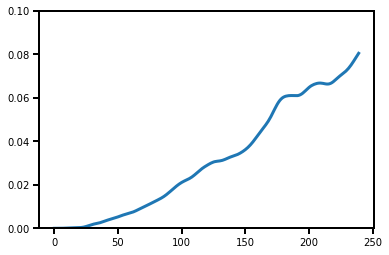

force loss : 0.14554182378421152


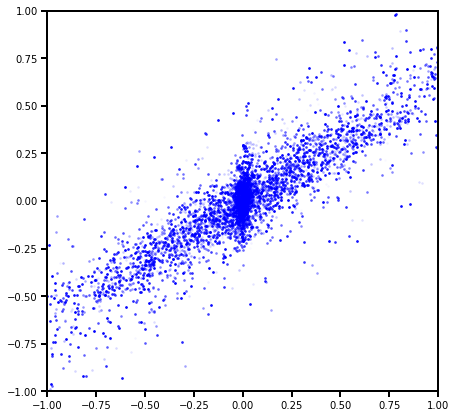

0.03689058870077133


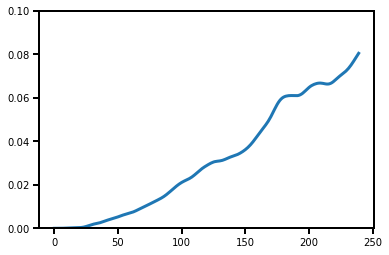

force loss : 0.14554150256895482


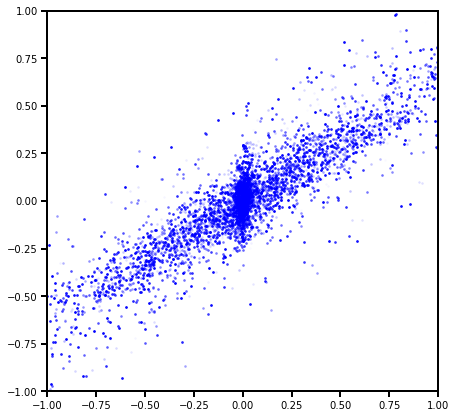

0.03688948228955269


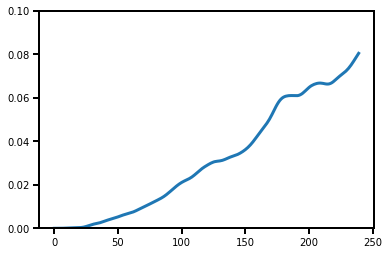

force loss : 0.1455412432551384


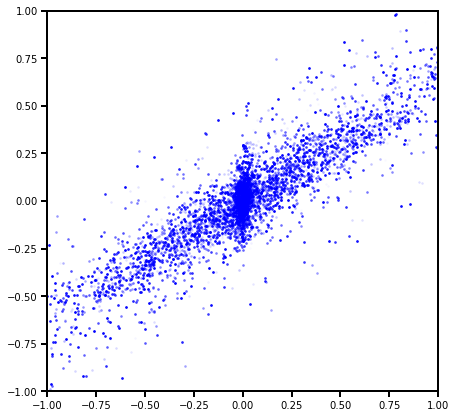

0.03688826411962509


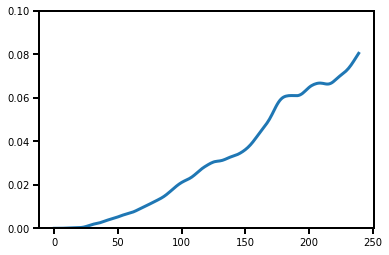

force loss : 0.14554102113820555


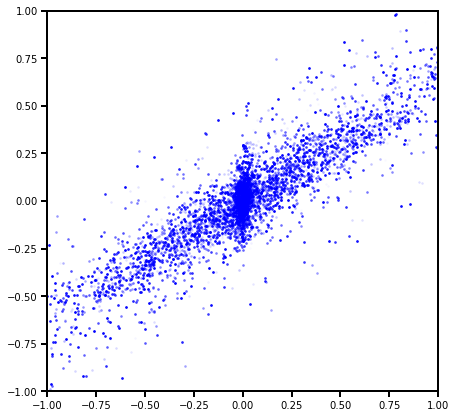

0.03688706085085869


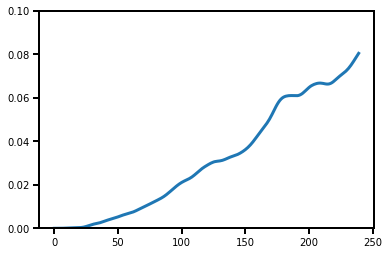

force loss : 0.14554080837651304


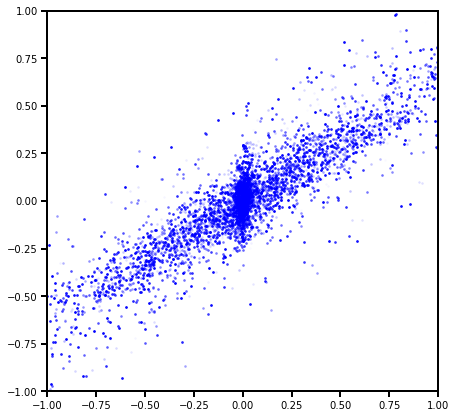

0.03688587620854378


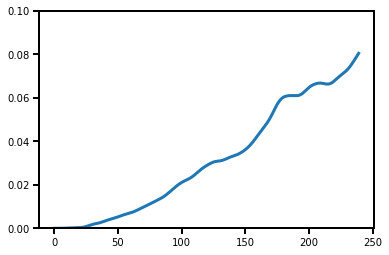

force loss : 0.1455406031774399


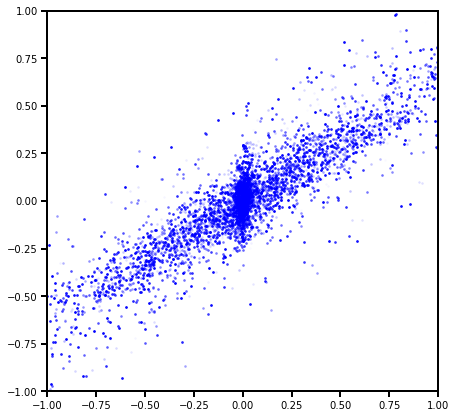

0.036884624511003494


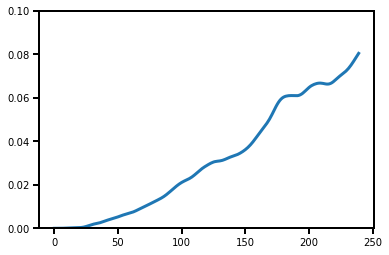

force loss : 0.14554043736000707


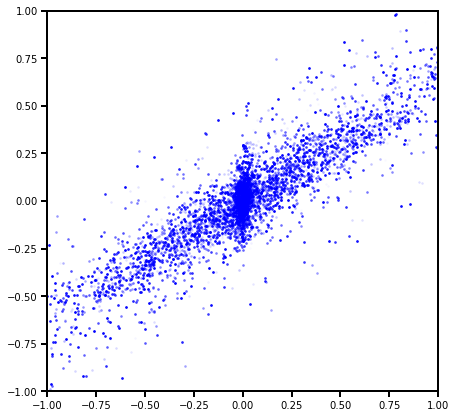

0.03688346594572067


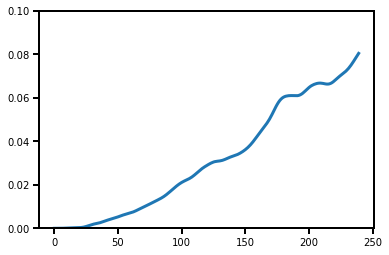

force loss : 0.1455402765843205


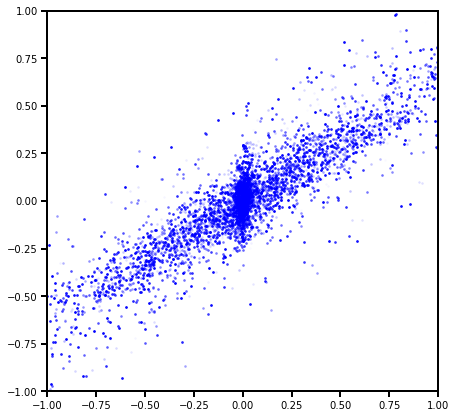

0.036882221698760986


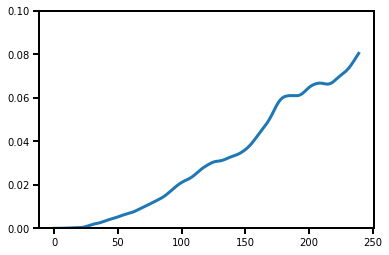

force loss : 0.1455401357515414


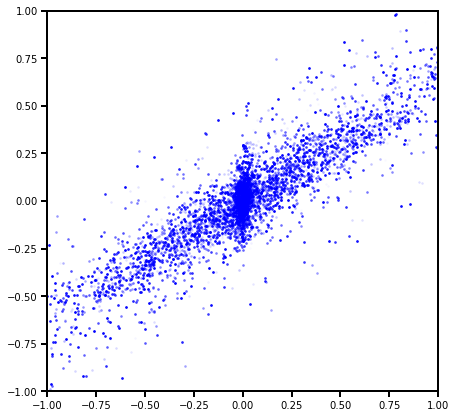

0.03688100725412369


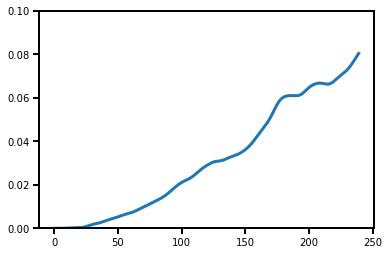

force loss : 0.1455400080273026


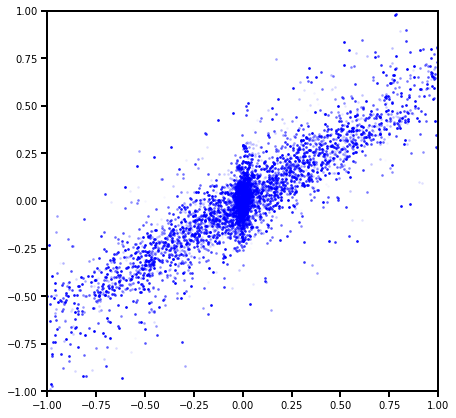

0.03687974810600281


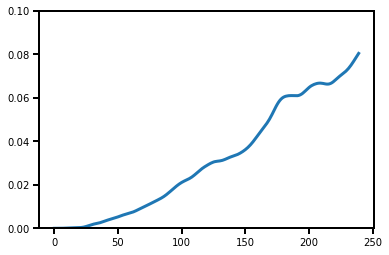

force loss : 0.14553989061063394


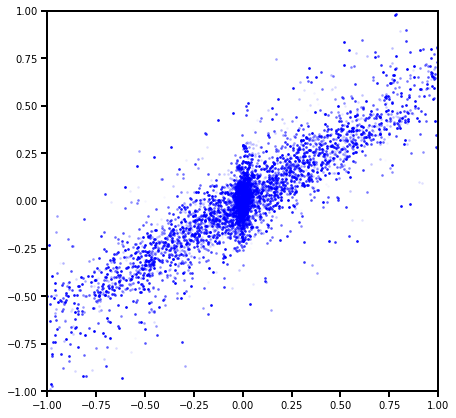

0.03687848895788193


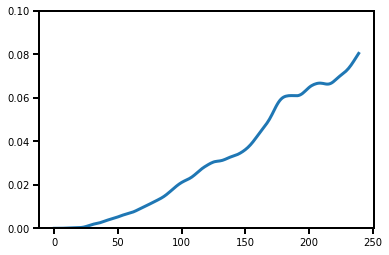

force loss : 0.14553977431435333


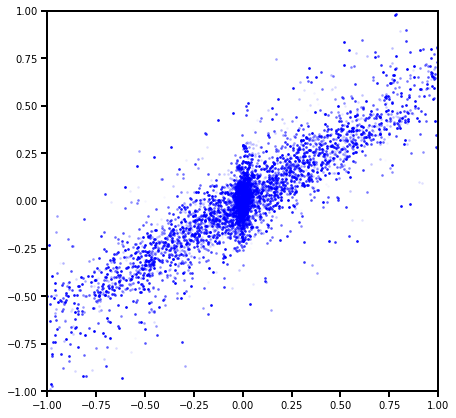

0.03687727451324463


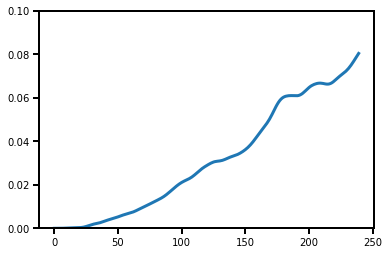

force loss : 0.14553969409456827


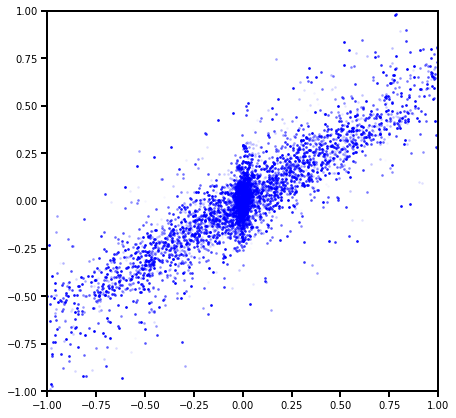

In [139]:
train_traj = []

for epoch in range(100):
    optimizer.zero_grad()

    system.set_velocities(vel_init)
    system.set_positions(traj[0])
    
    sim = Simulations(system, diffeq, method='verlet')
    
    
    vt, qt = sim.simulate(steps=steps , frequency=steps , dt=dt * 0.1 * skip)
    #print(qt[0])
    loss = (qt[::1] - qt_data[:t_len][::skip]).pow(2).mean()
    
    loss += (vt[::1] - v_data[:t_len][::skip]).pow(2).mean()
    
    if epoch % 20 == 0:
        train_traj.append(qt.detach().cpu())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(loss.item())
    
    scheduler.step(loss)
    
    plt.plot((qt - qt_data[:t_len][::skip]).pow(2).mean(-1).mean(-1).detach().cpu().numpy() )
    plt.ylim(0, 0.1)
    plt.show()
    
    validate(diffeq.model, f_traj, traj)
    

In [135]:
methane_nn_traj = [Atoms(positions=xyz, numbers=system.get_atomic_numbers()) for xyz in qt.detach().cpu().numpy()]
ase.io.write("benzene_nn.pdb", methane_nn_traj)
methane_nn_traj = mdtraj.load_pdb("benzene_nn.pdb")
show_mdtraj(methane_nn_traj)

NGLWidget(max_frame=1199)

In [262]:
atoms.get_temperature()

11.926000603409328

In [155]:
# EMT or LJ
uracil = np.load("../data/uracil_dft.npz")
uracil_traj = [Atoms(positions=xyz, numbers=uracil.f.z)  for xyz in uracil.f.R[:2000]]
ase.io.write("uracil.pdb", uracil_traj)
ethanol_pdb_traj = mdtraj.load_pdb("uracil.pdb")
show_mdtraj(ethanol_pdb_traj)

NGLWidget(max_frame=1999)

In [366]:
device = 2
atoms = Atoms(positions=uracil.f.R[0], numbers=uracil.f.z)  

In [367]:
vel_init = (uracil.f.R[1] - uracil.f.R[0])/ ( 0.5 * units.fs )

In [368]:
atoms.set_velocities(vel_init)
system = System(atoms, device=device)

In [369]:
# Initialize FF 

model = get_model(gnn_params)
GNN = GNNPotentials(model, system.get_batch(), system.get_cell_len(), cutoff=5.0, device=system.device)

# define the equation of motion to propagate 
diffeq = NoseHooverChain(GNN, 
        system,
        Q=50.0, 
        T=500.0 * units.kB,
        num_chains=5, 
        adjoint=True).to(device)

In [370]:
optimizer = torch.optim.Adam(list(diffeq.parameters() ), lr=1e-5)

In [372]:
t_len = 50
dt = 0.5
qt_data = torch.Tensor( uracil.f.R[:t_len] ).to(device)

In [373]:
train_traj = []

for epoch in range(1000):
    sim = Simulations(system, diffeq)
    vt, qt, pvt = sim.simulate(steps=t_len, frequency=t_len, dt=0.5 * units.fs)
    loss = (qt - qt_data).pow(2).mean()
    
    del system.traj
    
    if epoch % 20 == 0:
        train_traj.append(qt.detach().cpu())
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    print(loss.item())

0.02992996573448181
0.029708489775657654
0.029538286849856377
0.02936713397502899
0.02919200249016285
0.02901315502822399
0.028831597417593002
0.028648309409618378
0.02846444584429264
0.02828098088502884
0.02809853106737137
0.02791733667254448
0.027737241238355637
0.027557315304875374
0.027375908568501472
0.02719098888337612
0.026999881491065025
0.026799600571393967
0.026586176827549934
0.02635430172085762
0.026095399633049965
0.025794507935643196
0.025423334911465645
0.02491236850619316
0.023972420021891594
0.023850195109844208
0.02375594526529312
0.0236574225127697
0.023557567968964577
0.023456821218132973
0.02335529401898384
0.02325277402997017
0.023149173706769943
0.023044323548674583
0.02293800748884678
0.022830117493867874
0.022720277309417725
0.022608334198594093
0.022493911907076836
0.022376645356416702
0.022256040945649147
0.022131560370326042
0.02200237289071083
0.02186768501996994
0.021726185455918312
0.021576035767793655
0.02141452208161354
0.021237026900053024
0.0210350323

0.008812818676233292
0.00880639348179102
0.008800026960670948
0.008793669752776623
0.008787356317043304
0.008781078271567822
0.008774828165769577
0.008768612518906593
0.008762428537011147
0.008756277151405811
0.008750168606638908
0.008744078688323498
0.008738018572330475
0.00873199850320816
0.008726011030375957
0.008720049634575844
0.008714123629033566
0.008708230219781399
0.008702355436980724
0.008696514181792736
0.008690706454217434
0.008684917353093624
0.008679168298840523
0.008673432283103466
0.008667736314237118
0.008662072941660881
0.008656436577439308
0.008650814183056355
0.008645239286124706
0.008639674633741379
0.008634134195744991
0.008628633804619312
0.008623150177299976
0.00861769262701273
0.008612268604338169
0.008606850169599056
0.008601467125117779
0.008596127852797508
0.00859079509973526
0.008585482835769653
0.008580200374126434
0.008574948646128178
0.008569713681936264
0.008564508520066738
0.008559312671422958
0.008554146625101566
0.008549009449779987
0.008543890900909

0.0073691485449671745
0.007366395555436611
0.0073636495508253574
0.007360887713730335
0.00735812820494175
0.0073553756810724735
0.007352616637945175
0.0073498631827533245
0.00734711205586791
0.0073443506844341755
0.007341605145484209
0.0073388549499213696
0.007336101494729519
0.007333350367844105
0.007330592256039381
0.00732784066349268
0.00732509745284915
0.007322344463318586
0.007319596130400896
0.007316846400499344
0.0073140948079526424
0.007311346475034952
0.007308598607778549
0.007305847015231848
0.007303101476281881
0.007300350349396467
0.0072975982911884785
0.007294859737157822
0.007292110938578844
0.007289373781532049
0.007286618929356337
0.007283868733793497
0.007281123660504818
0.007278375327587128
0.00727563351392746
0.007272881921380758
0.007270134054124355
0.007267397828400135
0.007264654617756605
0.0072619011625647545
0.007259153760969639
0.007256409619003534
0.007253670133650303
0.007250922732055187
0.0072481706738471985
0.0072454349137842655
0.007242676801979542
0.00723

In [376]:
# run longer time 

t_len = 100
qt_data = torch.Tensor( uracil.f.R[:t_len] ).to(device)

sim = Simulations(system, diffeq)
vt, qt_test, pvt = sim.simulate(steps=t_len, frequency=t_len, dt=0.5 * units.fs)
del system.traj

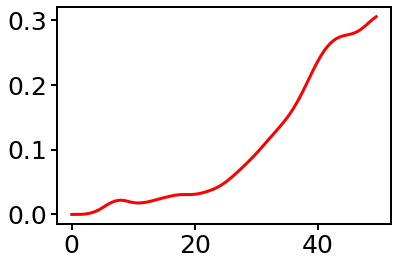

In [378]:
plt.plot([i * dt for i in range(t_len)], 
     (qt_test.detach().cpu() - qt_data.detach().cpu()).pow(2).sum(-1).mean(1).detach().cpu().numpy(), 
     c='red' ) 

plt.show()

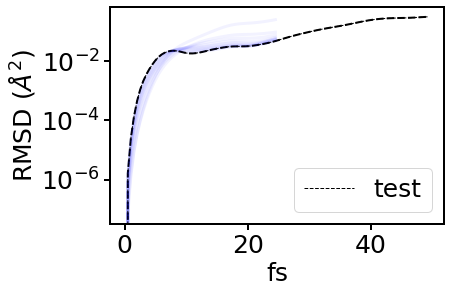

In [392]:

t_len_test = 100   
qt_data = torch.Tensor( uracil.f.R[:t_len_test ] ).to(device)    
plt.plot([i * dt for i in range(t_len_test)], 
     (qt_test.detach().cpu() - qt_data.detach().cpu()).pow(2).sum(-1).mean(1).detach().cpu().numpy(), 
     c='black', linestyle='--', linewidth=2 )     

t_len_train = 50
for i, rmsd in enumerate(train_traj[::5]):
    qt_data = torch.Tensor( uracil.f.R[:t_len_train] ).to(device)
    label = 'epoch {}'.format(i)
    plt.plot([i * dt for i in range(t_len_train)], 
         (rmsd - qt_data.detach().cpu()).pow(2).sum(-1).mean(1).detach().cpu().numpy(), 
         alpha= 1- epoch * 0.01, color='blue')

t_len_test = 100   
qt_data = torch.Tensor( uracil.f.R[:t_len_test ] ).to(device)    
plt.plot([i * dt for i in range(t_len_test)], 
     (qt_test.detach().cpu() - qt_data.detach().cpu()).pow(2).sum(-1).mean(1).detach().cpu().numpy(), 
     c='black', linestyle='--', linewidth=1, label='test')     
    
plt.ylabel("RMSD ($\AA^2$)")
plt.xlabel("fs")
plt.yscale("log")
plt.legend()
plt.show()
plt.close()

In [384]:
rmsd.shape

torch.Size([50, 12, 3])

In [385]:
qt_data.shape

torch.Size([50, 12, 3])

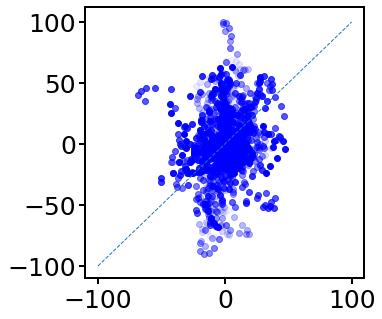

In [397]:
from nff.utils import compute_grad
# validate on the forces 
# compute
plt.figure(figsize=(5,5))

for i in range(50):
    
    x = qt[i].detach()
    x.requires_grad = True
    u = diffeq.model(x)
    f = -compute_grad(x, u) * 23.061
    plt.scatter(f.detach().cpu().numpy(),  uracil.f.F[i], alpha=1-0.02 * i, color='b')
    
plt.plot([-100, 100], [-100, 100], linewidth=1, linestyle='--')
    
plt.show()

In [229]:
atoms.get_number_of_atoms()

12

In [228]:
bath = torch.nn.Sequential( 
        torch.nn.Linear(12,12),
        torch.nn.Tanh(),
        torch.nn.Linear(12,12),
        torch.nn.Tanh(), 
        torch.nn.Linear(12,12),
        torch.nn.Tanh(), 
        torch.nn.Linear(12,12),
    )

In [138]:
# Plot NN MSE 

def plot_rmsd(qt, qt_data, t_len, dt=0.5):

    plt.plot([i * dt for i in range(t_len)], 
             (qt - qt_data).pow(2).sum(-1).mean(1).detach().cpu().numpy() )
    plt.ylabel("RMSD ($\AA^2$)")
    plt.xlabel("fs")
    plt.show()

In [402]:
# show movie 

uracil_nn_traj = [Atoms(positions=xyz, numbers=uracil.f.z) for xyz in qt_test.detach().cpu().numpy()]
ase.io.write("uracil_nn.pdb", uracil_nn_traj)
uracil_nn_traj = mdtraj.load_pdb("uracil_nn.pdb")
show_mdtraj(uracil_nn_traj)

NGLWidget(max_frame=99)

In [400]:
uracil = np.load("../data/uracil_dft.npz")
uracil_traj = [Atoms(positions=xyz, numbers=uracil.f.z)  for xyz in uracil.f.R[:t_len_train]]
ase.io.write("uracil.pdb", uracil_traj)
uracil_pdb_traj = mdtraj.load_pdb("uracil.pdb")
show_mdtraj(uracil_pdb_traj)

NGLWidget(max_frame=49)

In [140]:
a = np.array([1,1,1]) 
b = np.array([1,1,1]) 

In [142]:
np.stack((a, b))

array([[1, 1, 1],
       [1, 1, 1]])

In [11]:
Atoms(numbers=[1], positions=[[0, 1, 2]])

AttributeError: 'numpy.ndarray' object has no attribute 'name'

In [19]:
atoms = System(numbers=[1], positions=[[0, 1, 2]], device=0)

In [22]:
import pprint

In [27]:
pprint.pprint({'key':1, 'sd':23.135135}, indent=10)

{'key': 1, 'sd': 23.135135}
